<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [19]:
%%capture
pip install pyswarms

In [20]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [21]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [22]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [23]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [24]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [25]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [26]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [27]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [28]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [29]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [30]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [31]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


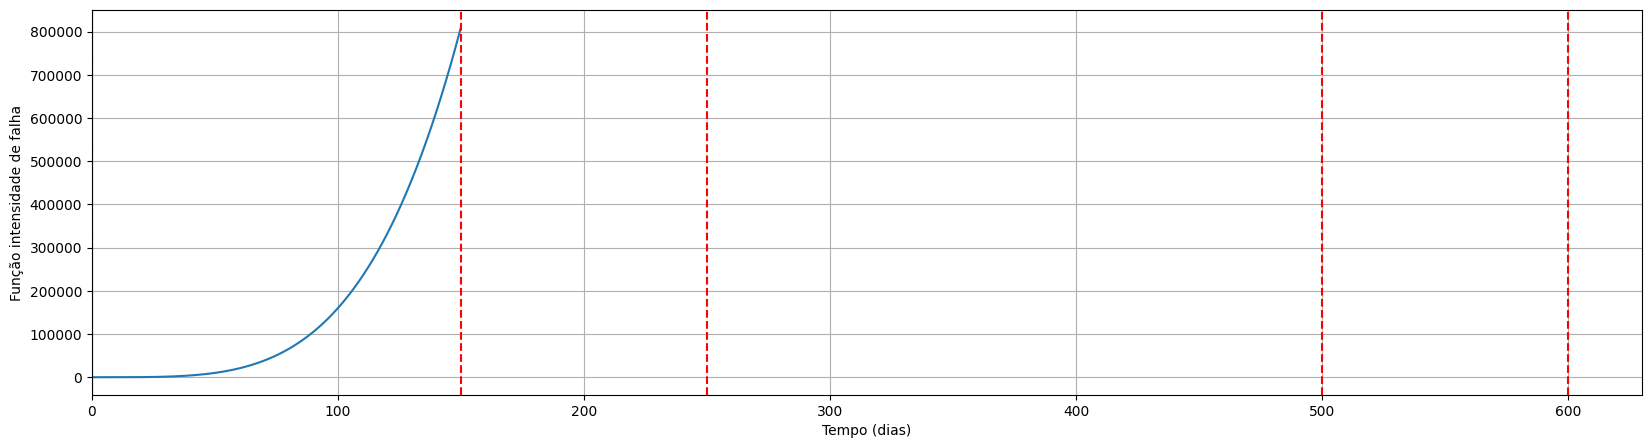

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [32]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [33]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(X):
    X = np.squeeze(X).astype(int)  # Converte X em uma matriz unidimensional de inteiros

    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0} # Dicionario para severidades

    global s
    T = [0]
    s_row = []
    cont = 0

    converter = np.vectorize(lambda x: int(x) % 2)
    X_int = converter(X)

    it = np.nditer(X_int, flags=['multi_index'])
    while not it.finished:
        number = it[0]
        index = it.multi_index
        if np.any(number == 1):
            number_int = int(number)
            if number_int in dict_severidades:
                s_row.append(dict_severidades[number_int])  # Severidade
                frac = number - number_int  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
        cont += 1
        it.iternext()

    s = []
    for row in range(m):
        s.append(s_row)

# A partir da solução define o número de ciclos
# A variável m é o número de sistemas em análise: em nosso exemplo m = 4
# Para novos dados esse parâmetro deve ser ajustado
# m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])


    if ck == 0:
        return CMP

# O modelo já está ajustado
# Utilizado para avaliar a solução candidata

# Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)


# Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

# Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    custo = min(Ctotal)

    print("")
    print('Custo = ', custo)
    print("=========================================================================")
    print("")

    # Retorna o custo
    return custo

In [34]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Lista para armazenar o custo em cada iteração
cost_history = []

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)
    cost_history.append(best_cost)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-07-04 21:29:05,001 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/100, best_cost=2e+3<ipython-input-33-16fb43797c80>:86: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:   2%|▏         |2/100, best_cost=2e+3



Número de ciclos de manutenção: 0 5
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []


Número de ciclos de manutenção: 1075 5
Tempos para manutenções preventivas: [0, 0, 150, 180, 210, 300, 360, 390, 510, 570, 600, 630, 660, 810, 870, 930, 990, 1080, 1140, 1440, 1530, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1860, 1890, 1920, 1950, 2100, 2130, 2190, 2250, 2310, 2340, 2370, 2610, 2670, 2820, 2850, 2880, 2910, 2940, 2970, 3030, 3060, 3120, 3240, 3270, 3330, 3390, 3450, 3480, 3570, 3690, 3810, 3900, 4020, 4080, 4110, 4140, 4260, 4380, 4440, 4500, 4530, 4590, 4620, 4650, 4740, 4770, 4920, 4980, 5280, 5310, 5370, 5430, 5460, 5490, 5550, 5640, 5670, 5700, 5790, 5880, 5970, 6060, 6090, 6150, 6180, 6210, 6270, 6390, 6420, 6480, 6540, 6600, 6630, 6660, 6690, 6780, 6840, 6990, 7020, 7050, 7110, 7380, 7410, 7560, 7650, 7710, 7770, 7800, 7830, 7920, 7950, 7980, 8040, 8070, 8160, 8190, 8220, 8430, 8460, 8490, 8580, 8640, 8760, 8850, 8940, 8970, 9060, 9120, 9150, 9240,

pyswarms.single.global_best:   4%|▍         |4/100, best_cost=2e+3

Media de falhas:  [0, 0.0, 248832.00000000003, 2891284.942735999, 5908557.924596766, 12206873.657774614, 23953037.20585111, 168522000.73408493, 370068104.1957761, 513569437.4781499, 2120459969.180078, 3413182452.7912083, 4228700640.232038, 5221321116.594683, 6418450502.210584, 9741993810.187569, 11744650334.12077, 25607058178.967728, 29776568042.292187, 34533582192.21345, 46551851718.126076, 53447440109.26597, 70516021983.83981, 91740210018.4897, 117836792016.59625, 132464251317.16524, 214405204774.331, 237622090521.45502, 291998572328.96857, 321916472073.1156, 391316675289.03046, 520931218899.0755, 568489695734.7163, 619613327202.4149, 736035559671.0583, 799064021242.708, 1025216963980.7239, 1107214184506.9617, 1194557176499.493, 1287503176937.9412, 1615557843065.0396, 1733652604171.9626, 1858760931424.8774, 1991190694912.613, 2131258645569.7344, 2279290541460.612, 2606390356362.965, 2969960874337.929, 3163022956790.3745, 3366199754495.968, 3811774021033.9385, 5545828412037.811, 61961

pyswarms.single.global_best:   6%|▌         |6/100, best_cost=2e+3

Media de falhas:  [0, 60466176.00000001, 77120322.62272497, 591754552.7526054, 735255886.0349792, 4511268196.69265, 5326786384.13348, 6319406860.496125, 11218161074.289883, 19106724060.88306, 26242750361.31052, 58888788191.3096, 317172043962.4895, 371548525770.00305, 568149908491.006, 612333042184.4194, 713432743130.9849, 829854975599.6284, 1448976101901.8457, 4092588488276.918, 4538162754814.889, 4774077957732.989, 6978882217451.123, 8510192923989.393, 9355257271601.83, 11324696558502.193, 12405217905756.174, 12970937194665.637, 21896601104906.703, 26859470594978.36, 31422416617588.94, 38093475796035.836, 47689572823183.73, 66203779176840.68, 68393432609310.18, 80738593013143.05, 83320021175623.81, 88741691553624.89, 94457021222261.2, 110513506671454.02, 141508035374215.34, 173645319987446.5, 193991603855580.0, 204712742428124.1, 221839245289350.47, 253441793275533.56, 259990592873690.12, 273606061846191.88, 295277210339770.2, 371894419009818.9, 409301641956729.8, 449709750138564.1, 4

pyswarms.single.global_best:  11%|█         |11/100, best_cost=2e+3



Número de ciclos de manutenção: 102 5
Tempos para manutenções preventivas: [0, 210, 510, 930, 1860, 2100, 3450, 4440, 4650, 5670, 5700, 6270, 6300, 6480, 7590, 7920, 8040, 9450, 9510, 9540, 9630, 10800, 10830, 11010, 12150, 12420, 13290, 13560, 14700, 14790, 18300, 18630, 19650, 19830, 21750, 22320, 23220, 23490, 24810, 25770, 25860, 25920, 26280, 27090, 27450, 28620, 28710, 29550, 30540, 30660, 31470, 31500, 31770, 34170, 34440, 34470, 35850, 36450, 38340, 38880, 39150, 39960, 40590, 40860, 40920, 41850, 42060, 43620, 44580, 45030, 45540, 45600, 45780, 46320, 48480, 48660, 49350, 50580, 50910, 51300, 51420, 51720, 53340, 54690, 55650, 56490, 57780, 58140, 58680, 58770, 59910, 60780, 61590, 62520, 64020, 68130, 68760, 69750, 69870, 70170, 70620, 71190, 71970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.

pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=2e+3


Custo =  648000013.3333335



Número de ciclos de manutenção: 918 5
Tempos para manutenções preventivas: [0, 150, 180, 210, 360, 510, 630, 660, 810, 870, 900, 930, 990, 1020, 1080, 1140, 1200, 1350, 1380, 1440, 1530, 1590, 1620, 1650, 1680, 1710, 1770, 1860, 1950, 2040, 2100, 2130, 2190, 2340, 2370, 2670, 2820, 2850, 2880, 2940, 3030, 3060, 3330, 3390, 3450, 3480, 3570, 3690, 3810, 3900, 4110, 4140, 4230, 4350, 4470, 4500, 4530, 4620, 4650, 4710, 4740, 4890, 4920, 4980, 5070, 5190, 5280, 5310, 5370, 5490, 5550, 5640, 5670, 5700, 5790, 5880, 5910, 5970, 6060, 6090, 6150, 6180, 6210, 6390, 6420, 6450, 6480, 6510, 6540, 6630, 6660, 6690, 6780, 6840, 6900, 6990, 7020, 7110, 7200, 7230, 7380, 7410, 7560, 7650, 7710, 7800, 7830, 7950, 8070, 8160, 8190, 8220, 8430, 8460, 8640, 8730, 8760, 8850, 8910, 9060, 9120, 9270, 9330, 9510, 9600, 9660, 9750, 9780, 9870, 9930, 10020, 10080, 10140, 10170, 10230, 10260, 10290, 10440, 10530, 10590, 10680, 10740, 10800, 10950, 11010, 11100, 11190, 11310, 11

pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=2e+3

Media de falhas:  [0, 24300000.000000004, 33145274.85024995, 44891438.39832645, 559525668.528207, 6874226571.112124, 9212568492.09076, 22073614359.921608, 29209640660.349068, 38549142967.98923, 50567412493.901855, 57463000885.04175, 74531582759.61559, 125433206587.14862, 257400081574.44083, 311776563381.95435, 508377946102.9573, 552561079796.3707, 600119556632.0116, 651243188099.7102, 706128772274.1464, 830834790681.64, 1365048943954.147, 1969896975349.6418, 2102326738837.3774, 3161536781879.921, 3564546486156.163, 4010120752694.134, 8421841126879.306, 8829659506843.807, 9710996440168.1, 10668369231980.805, 12278953327352.244, 12844672616261.707, 19695320914878.312, 21390667041828.973, 27521915554133.863, 32237090543147.125, 42405249075289.97, 54966237319966.78, 63129727469554.83, 83185691779645.61, 111662462302462.48, 133960403231280.95, 141885520140968.9, 154607882485842.4, 173170133372427.78, 193516417240561.28, 215772359772496.62, 221523625354143.53, 227402459458384.88, 23963796027

pyswarms.single.global_best:  21%|██        |21/100, best_cost=2e+3



Número de ciclos de manutenção: 64 5
Tempos para manutenções preventivas: [0, 1710, 1860, 2670, 4440, 5700, 6270, 6300, 7590, 7770, 8040, 10590, 10800, 10830, 12150, 12420, 13290, 14790, 17400, 17580, 18090, 18300, 22530, 23490, 25860, 27090, 27600, 29520, 29550, 29820, 30540, 30660, 30960, 32580, 33270, 33630, 35640, 37860, 38880, 39150, 39630, 40590, 43050, 43620, 44250, 45030, 45690, 46890, 50580, 50790, 55650, 56190, 57600, 58680, 58950, 59730, 60780, 61590, 65070, 65460, 66630, 68130, 68760, 70800, 71190]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=2e+3

Media de falhas:  [0, 60466176.00000001, 77120322.62272497, 11928510194.37503, 29811081737.339413, 36947108037.76688, 60326855559.61137, 340379724966.7086, 508667517434.0465, 589683301332.827, 739759211735.2361, 1526818909481.1733, 2131666940876.6682, 11138984502549.455, 13029584164301.646, 13531526446791.959, 14612047794045.94, 15177767082955.402, 24103430993196.47, 29066300483268.125, 30115362205937.68, 34830537194950.94, 59323087843147.71, 67486577992735.76, 69615550116599.81, 87231632369453.28, 92653302747454.36, 101415497331573.89, 110882969143704.47, 114147773368575.23, 136445714297393.7, 144370831207081.66, 199032321918943.22, 227374932445605.8, 233253766549847.16, 245489267363832.2, 271964590096846.94, 278796804025236.84, 300467952518815.2, 407976115684364.9, 417419731821679.56, 427048214489665.94, 446995528734638.94, 457194921897494.7, 500780962375209.2, 523542710088403.0, 547160627923996.5, 584467609838861.4, 597208103081024.1, 610179891516419.2, 650987565105440.9, 6792541737

pyswarms.single.global_best:  31%|███       |31/100, best_cost=2e+3



Número de ciclos de manutenção: 36 5
Tempos para manutenções preventivas: [0, 1860, 2670, 3270, 4440, 4650, 8040, 10800, 10830, 12420, 13890, 15720, 18630, 22530, 22980, 23490, 26940, 28980, 29820, 30540, 30660, 36120, 40860, 40920, 43020, 43620, 45690, 46320, 48480, 50910, 58680, 58950, 62220, 62520, 65460, 66630, 68130]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873

pyswarms.single.global_best:  36%|███▌      |36/100, best_cost=2e+3



Número de ciclos de manutenção: 306 5
Tempos para manutenções preventivas: [0, 150, 180, 210, 630, 810, 870, 990, 1440, 1650, 1710, 1950, 2100, 2370, 2970, 3390, 3480, 3570, 3810, 4230, 4260, 4470, 4530, 4740, 4920, 5310, 5670, 5700, 6150, 6270, 6300, 6420, 6540, 6660, 6690, 6990, 7410, 7710, 7800, 7920, 8430, 8580, 9120, 9150, 9240, 9510, 9750, 9780, 10020, 11010, 11100, 11400, 11610, 12120, 12240, 12570, 12630, 12750, 12840, 12960, 12990, 13140, 13170, 13230, 13290, 13440, 13560, 13740, 13920, 13980, 14580, 14700, 14790, 14910, 15030, 15060, 16110, 16350, 16500, 16650, 16740, 16770, 16950, 17190, 17340, 17460, 17580, 18210, 18300, 18420, 18510, 18630, 18660, 19470, 19620, 19650, 19800, 19860, 20100, 20340, 20430, 20580, 20790, 20850, 21270, 21300, 21630, 21930, 22200, 22320, 22470, 22950, 23010, 23190, 23220, 23250, 23370, 23550, 23670, 23910, 24090, 24150, 24420, 24690, 24780, 25140, 25860, 26040, 26100, 26220, 26520, 27060, 27360, 27840, 28020, 28080, 28260, 28680, 28740, 29010, 

pyswarms.single.global_best:  39%|███▉      |39/100, best_cost=2e+3



Número de ciclos de manutenção: 41 5
Tempos para manutenções preventivas: [0, 930, 4650, 6300, 7050, 7590, 7770, 8040, 8130, 9630, 13890, 15210, 18570, 21810, 22980, 23490, 24990, 26550, 26940, 27600, 29460, 29550, 29820, 33630, 33720, 37590, 39900, 40860, 45690, 45930, 48750, 58650, 58680, 58950, 60780, 62160, 62220, 62520, 65460, 66180, 67170, 68130]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469340287

pyswarms.single.global_best:  45%|████▌     |45/100, best_cost=2e+3



Número de ciclos de manutenção: 191 5
Tempos para manutenções preventivas: [0, 210, 930, 1590, 1890, 1950, 2100, 2970, 3480, 4260, 4470, 4980, 5310, 5670, 5700, 6270, 6300, 6690, 7770, 7800, 8580, 8970, 9150, 9240, 9270, 10290, 11010, 11100, 11400, 11610, 12120, 12240, 12570, 12630, 12960, 12990, 13230, 13290, 13530, 13920, 13980, 14700, 14910, 15030, 16110, 16500, 16740, 17190, 17580, 17880, 18210, 18420, 18510, 18660, 19470, 19650, 19800, 19860, 20100, 20340, 20580, 20670, 20820, 21270, 21300, 21630, 22200, 22320, 22470, 22950, 23100, 23550, 23670, 23910, 24150, 24690, 25140, 25860, 25950, 26760, 27060, 27240, 28020, 28260, 28680, 28710, 28950, 29010, 29310, 29700, 30240, 30420, 30870, 31620, 31770, 31980, 32070, 32280, 32580, 33330, 33420, 34440, 35430, 35790, 36000, 37620, 38130, 38340, 39390, 39510, 39630, 39900, 40140, 40530, 40920, 41970, 42660, 43020, 43140, 43350, 43740, 44190, 44250, 44310, 44580, 44880, 45540, 46410, 46530, 47340, 47700, 48060, 49050, 49470, 49560, 49980, 

pyswarms.single.global_best:  51%|█████     |51/100, best_cost=2e+3



Número de ciclos de manutenção: 51 5
Tempos para manutenções preventivas: [0, 2670, 5490, 7050, 7590, 8040, 8130, 10680, 12420, 12900, 13890, 16650, 17790, 18630, 19830, 21060, 22530, 24300, 24990, 26100, 26940, 29550, 31500, 32160, 33630, 33720, 33780, 34740, 39120, 39900, 40860, 45030, 45930, 45990, 46320, 47070, 48450, 48750, 48900, 48960, 50490, 52770, 58080, 58680, 58950, 62160, 62220, 62400, 63540, 64170, 66180, 67170]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 

pyswarms.single.global_best:  54%|█████▍    |54/100, best_cost=2e+3



Número de ciclos de manutenção: 113 5
Tempos para manutenções preventivas: [0, 210, 930, 1590, 1950, 3570, 4920, 4980, 5310, 5670, 7500, 7770, 7800, 7980, 8580, 9150, 9240, 9510, 10830, 11610, 12030, 12120, 12630, 13290, 13530, 13560, 13980, 14880, 17280, 17400, 18210, 18420, 19470, 19650, 20400, 20580, 20820, 21270, 21300, 21630, 22200, 22320, 22470, 22500, 22650, 23250, 23670, 23910, 24150, 25140, 26760, 27090, 28020, 28950, 29430, 30150, 31110, 32280, 32580, 33330, 33720, 34440, 35430, 36180, 37620, 38130, 38340, 39510, 39630, 40530, 41970, 42780, 43020, 43050, 43350, 44190, 44580, 45600, 46530, 47700, 49470, 50100, 50580, 50700, 50910, 51720, 52170, 52470, 53040, 53220, 54210, 56340, 56490, 58200, 58560, 59250, 60600, 60690, 61140, 61620, 62520, 62940, 63450, 63870, 63930, 65010, 65430, 66960, 67110, 67440, 67470, 67860, 68220, 69120]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,

pyswarms.single.global_best:  56%|█████▌    |56/100, best_cost=2e+3



Número de ciclos de manutenção: 50 5
Tempos para manutenções preventivas: [0, 1440, 2100, 3060, 3090, 4800, 4830, 4920, 7380, 7770, 7980, 11460, 12330, 13890, 18420, 18630, 19650, 20820, 21270, 22350, 22530, 25140, 26100, 26940, 29010, 33720, 35430, 37290, 37860, 39510, 39810, 39900, 41700, 43860, 45930, 46320, 47760, 48750, 48780, 48960, 52770, 54120, 58290, 58500, 58680, 62220, 62400, 65970, 66450, 66960, 71910]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469340287366

pyswarms.single.global_best:  60%|██████    |60/100, best_cost=2e+3



Número de ciclos de manutenção: 49 5
Tempos para manutenções preventivas: [0, 1710, 2610, 3810, 6150, 6270, 6690, 6990, 8040, 9990, 11730, 12900, 15090, 18300, 22320, 23550, 24990, 25860, 26100, 27450, 28710, 29820, 30420, 30660, 31440, 31890, 32010, 33630, 34920, 36450, 38970, 44130, 44310, 44850, 45690, 45900, 47220, 47550, 51780, 52230, 55710, 58560, 58950, 59910, 63540, 63960, 64170, 65730, 69090, 69690]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693

pyswarms.single.global_best:  64%|██████▍   |64/100, best_cost=2e+3



Número de ciclos de manutenção: 79 5
Tempos para manutenções preventivas: [0, 210, 930, 1950, 3810, 4650, 4770, 4920, 6270, 9150, 10290, 11610, 12120, 13290, 13470, 13560, 17400, 18210, 18570, 19170, 19470, 19650, 20400, 20580, 21300, 22500, 23250, 23670, 26760, 27090, 31110, 31500, 32280, 32340, 32580, 33510, 34050, 34440, 36180, 37020, 37620, 38130, 38340, 38880, 39390, 39510, 41970, 43020, 43350, 44250, 44310, 46530, 47040, 47340, 50100, 50580, 50700, 50910, 50970, 51720, 52140, 52170, 52530, 53940, 54210, 55380, 56070, 58560, 59910, 60600, 60690, 63450, 66720, 66960, 67110, 67440, 67470, 71190, 71730, 71880]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.

pyswarms.single.global_best:  68%|██████▊   |68/100, best_cost=2e+3



Número de ciclos de manutenção: 41 5
Tempos para manutenções preventivas: [0, 3090, 5880, 5970, 6840, 9630, 11460, 13890, 15630, 18210, 18420, 19260, 19650, 22530, 24990, 25140, 25260, 29760, 31440, 33720, 34770, 35430, 37290, 37590, 39720, 43830, 43860, 46320, 47760, 48750, 48780, 48900, 52770, 53520, 54120, 58290, 58500, 62160, 62220, 62400, 64170, 66450]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693

pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=2e+3



Número de ciclos de manutenção: 65 5
Tempos para manutenções preventivas: [0, 210, 930, 2610, 3270, 3690, 3810, 4740, 6210, 8040, 9150, 10830, 11610, 12120, 12900, 13440, 13800, 15030, 18090, 18300, 19170, 19470, 20400, 20580, 20790, 21780, 22110, 22320, 23250, 23550, 25770, 26160, 27570, 28260, 28710, 29820, 30420, 31500, 32010, 34170, 35850, 36180, 39150, 40290, 45030, 45690, 46530, 47280, 47550, 48510, 50100, 50910, 51000, 51720, 51780, 52230, 52530, 52680, 53940, 54930, 59250, 59910, 60600, 67110, 68220, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.39

pyswarms.single.global_best:  74%|███████▍  |74/100, best_cost=2e+3



Número de ciclos de manutenção: 41 5
Tempos para manutenções preventivas: [0, 810, 1590, 3090, 4920, 5310, 5970, 7200, 14010, 15780, 17280, 18210, 19650, 20580, 21270, 21300, 22530, 23070, 23100, 23490, 24540, 25140, 33510, 33720, 38130, 39510, 40770, 41700, 43020, 43410, 46410, 49020, 50580, 52770, 54120, 54210, 55170, 58290, 61140, 62220, 66450, 71910]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402

pyswarms.single.global_best:  80%|████████  |80/100, best_cost=2e+3



Número de ciclos de manutenção: 52 5
Tempos para manutenções preventivas: [0, 210, 1710, 1890, 2610, 3270, 3810, 5670, 6210, 7590, 8040, 9150, 9540, 11610, 12120, 18300, 23250, 23550, 25470, 25770, 26160, 29820, 30420, 31440, 31500, 35730, 37860, 39150, 43320, 43860, 44160, 44250, 45030, 45690, 45870, 46530, 47550, 50100, 51780, 52680, 53820, 53940, 58710, 59910, 60150, 61680, 62130, 64170, 64440, 65400, 66720, 67110, 68220]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469340287

pyswarms.single.global_best:  86%|████████▌ |86/100, best_cost=2e+3



Número de ciclos de manutenção: 42 5
Tempos para manutenções preventivas: [0, 4770, 5250, 5310, 6150, 9630, 10290, 13290, 13530, 15630, 16140, 17160, 18210, 18420, 19650, 19920, 21270, 23100, 24810, 25140, 30870, 32940, 33510, 33720, 37770, 40590, 40770, 46410, 48900, 49020, 52770, 53520, 54120, 55170, 55560, 58290, 58530, 61140, 62220, 65430, 66900, 70050, 70380]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.39346934028736

pyswarms.single.global_best:  89%|████████▉ |89/100, best_cost=2e+3


Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 4678757435232.0, 50495732408066.16, 73412037151855.58, 166734395611773.0, 710930165878445.2, 1509144830089233.5, 1902231328789850.5, 1.9463267707997036e+16, 2.6470796703885068e+16, 7.13848

pyswarms.single.global_best:  95%|█████████▌|95/100, best_cost=2e+3



Número de ciclos de manutenção: 42 5
Tempos para manutenções preventivas: [0, 1650, 5220, 5310, 6090, 6840, 7380, 9120, 9600, 9900, 10620, 11130, 15630, 18210, 18630, 19650, 19920, 20580, 21270, 21300, 21630, 23070, 23100, 30870, 31350, 38130, 38340, 39270, 39510, 41520, 51000, 53520, 54030, 54210, 55170, 55380, 55560, 55950, 56340, 58530, 59460, 61140, 62220]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 

pyswarms.single.global_best:  98%|█████████▊|98/100, best_cost=2e+3



Número de ciclos de manutenção: 39 5
Tempos para manutenções preventivas: [0, 210, 2010, 4740, 5670, 5880, 5970, 8850, 11760, 13230, 18930, 19170, 19230, 23730, 24420, 30420, 31500, 32010, 35730, 35910, 37770, 37860, 39120, 39570, 40230, 43350, 43830, 43860, 45030, 47760, 50250, 52050, 58710, 59910, 60150, 61680, 62640, 65070, 69090, 71940]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=2e+3
2023-07-04 21:29:10,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72544601 0.731142   0.37792845 0.53625365 0.09091935 0.73209035
 0.86793906 0.98745305 0.12080428 0.40552645 0.78641915 0.17813371
 0.63536683 0.45718171 0.55019286 0.15403489 0.0651295  0.91124098
 0.33171991 0.31027264 0.80268641 0.81763034 0.91833537 0.50353188]
2023-07-04 21:29:10,993 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 40 5
Tempos para manutenções preventivas: [0, 2610, 3270, 4470, 4650, 6480, 10620, 11610, 12570, 13800, 14010, 15030, 18060, 18090, 20580, 21750, 22320, 25470, 28290, 29850, 30750, 35100, 39510, 39540, 45870, 49020, 50970, 51900, 53940, 54120, 55710, 60150, 60930, 65970, 66960, 67410, 68130, 68220, 68730, 69480, 71460]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:11,102 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.71893535 0.72886745 0.38125455 0.53021213 0.08548934 0.72782666
 0.86325578 0.98066742 0.11548844 0.40612539 0.7807733  0.16983963
 0.63360479 0.45363788 0.53999563 0.15412042 0.07843018 0.91128729
 0.32871829 0.31493433 0.8081243  0.81461114 0.93883413 0.5073126 ]
2023-07-04 21:29:11,104 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 33 5
Tempos para manutenções preventivas: [0, 1650, 5220, 5310, 6840, 7380, 9900, 10620, 11130, 13080, 16770, 18210, 19650, 19920, 24810, 34710, 36150, 40170, 44160, 47070, 47340, 47670, 50970, 55560, 56250, 56550, 58530, 60630, 62220, 64530, 65970, 66960, 68130, 68220]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469340287

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:11,203 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.71481482 0.72867772 0.37980772 0.52688702 0.08095507 0.72334251
 0.8556985  0.97364737 0.1145213  0.40567884 0.77802917 0.17212494
 0.63161066 0.45191235 0.53897874 0.17702111 0.08011401 0.90926732
 0.32713037 0.31829131 0.80790508 0.80321024 0.93627351 0.50688235]
2023-07-04 21:29:11,204 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 56 5
Tempos para manutenções preventivas: [0, 1650, 3690, 5220, 5310, 6840, 7080, 7380, 8100, 9270, 9870, 9900, 11130, 12450, 16770, 17490, 18210, 18630, 19320, 19650, 19920, 22530, 25140, 26670, 28470, 30870, 32340, 34710, 36150, 36570, 39480, 44520, 46320, 46410, 47070, 47340, 47670, 47730, 48900, 50970, 51000, 53610, 55170, 55560, 56250, 56550, 58440, 58530, 58680, 60630, 61140, 62220, 62970, 64530, 66240, 66900, 70770]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:11,343 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.71191908 0.7287052  0.37815724 0.52474448 0.07934461 0.72035317
 0.85251384 0.96948303 0.11397561 0.40527175 0.77786122 0.17425577
 0.63008619 0.45121289 0.54062737 0.19106251 0.07782622 0.90755516
 0.32653029 0.32026445 0.80740329 0.79510311 0.93209518 0.50612115]
2023-07-04 21:29:11,346 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 79 5
Tempos para manutenções preventivas: [0, 1650, 3510, 3690, 5220, 5310, 5910, 6840, 7080, 7380, 8100, 9270, 9870, 9900, 10290, 10740, 11130, 12450, 15330, 16770, 17490, 18210, 18630, 19320, 19650, 19920, 22530, 23070, 23670, 25140, 26670, 28470, 29460, 30180, 30390, 30870, 32340, 34710, 34770, 35490, 36150, 39090, 39480, 40470, 40530, 43800, 44430, 44520, 46320, 47070, 47730, 48900, 50190, 50970, 51000, 53610, 55380, 55560, 56250, 56550, 56670, 56820, 58260, 58440, 58500, 58530, 58680, 61140, 62220, 62430, 62820, 62850, 63150, 64680, 65010, 66240, 66450, 66900, 70050, 70770]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:11,475 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.71167249 0.72892974 0.37666851 0.52411867 0.07958044 0.71880522
 0.85063919 0.96882667 0.11377153 0.40490636 0.77991061 0.17717868
 0.62897955 0.45124836 0.54367483 0.198105   0.07304232 0.90609055
 0.3264749  0.31993794 0.80575511 0.79161555 0.92486871 0.50506234]
2023-07-04 21:29:11,478 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 128 5
Tempos para manutenções preventivas: [0, 1380, 1650, 3510, 3690, 3810, 4500, 4830, 5220, 5310, 5910, 5970, 6270, 6390, 6840, 7080, 7350, 7380, 8100, 9270, 9570, 9870, 9900, 10290, 10440, 10590, 10740, 11460, 12450, 12900, 15330, 15630, 16770, 17160, 17490, 18210, 18630, 19320, 19920, 20820, 21090, 21810, 22530, 23070, 23670, 24420, 25140, 26670, 27960, 27990, 28380, 28710, 29100, 29460, 30180, 30390, 30870, 31140, 31770, 32340, 32700, 34050, 34350, 34710, 34770, 35490, 35880, 35910, 36150, 36660, 37470, 37950, 38790, 39090, 39480, 39570, 40260, 40470, 40530, 43140, 43380, 43800, 44130, 44430, 44520, 47010, 47430, 47730, 48150, 48900, 49890, 50190, 51000, 51330, 51630, 52770, 53490, 53610, 53790, 55020, 55380, 55560, 56250, 56670, 56820, 57540, 58260, 58500, 58530, 58680, 58980, 61140, 62220, 62430, 62820, 62850, 63150, 63960, 64680, 65010, 66180, 66240, 66450, 66900, 68190, 69060, 70050, 70500, 70770]
Severidade para cada subsistema: [0.25, 0.25,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:11,615 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.71498409 0.72963697 0.3756872  0.52445994 0.08172115 0.71826323
 0.85375866 0.96943981 0.11545658 0.40472647 0.78341648 0.17989287
 0.62975627 0.45200128 0.54723745 0.20393509 0.06731492 0.90483071
 0.32665279 0.31958626 0.80364333 0.79375456 0.91685885 0.5037147 ]
2023-07-04 21:29:11,619 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 213 5
Tempos para manutenções preventivas: [0, 1380, 1650, 2370, 2460, 2790, 3090, 3510, 3810, 4110, 4200, 4500, 4830, 5220, 5310, 5910, 5940, 5970, 6270, 6390, 6690, 7080, 7140, 7350, 7380, 8100, 8550, 8820, 8850, 9270, 9300, 9570, 9870, 9900, 10290, 10440, 10590, 10740, 11460, 12390, 12450, 12900, 13170, 13590, 13620, 13890, 14910, 15330, 15630, 16440, 16770, 17160, 17490, 17880, 18210, 18630, 19320, 20370, 20820, 21090, 21810, 22530, 23070, 24270, 24420, 25140, 25380, 25710, 25920, 26670, 26820, 26850, 27150, 27510, 27960, 27990, 28380, 29100, 29400, 29460, 30180, 30390, 30450, 30870, 31140, 31890, 32340, 32700, 33330, 33630, 33780, 34050, 34350, 34710, 34770, 35070, 35490, 35880, 35910, 36150, 36210, 36660, 37350, 37470, 37740, 37950, 38070, 38760, 38790, 39090, 39390, 39480, 39570, 39810, 40260, 40470, 40530, 41910, 42060, 42480, 42660, 43140, 43380, 43800, 43830, 44130, 44430, 44520, 45150, 45240, 45270, 45300, 46020, 46080, 46380, 46440, 46980, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:11,757 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.71831136 0.73037579 0.37528337 0.52611778 0.08535336 0.71934955
 0.85670071 0.97205215 0.11709362 0.40460127 0.7874449  0.18208011
 0.63100054 0.4532937  0.55101793 0.19539167 0.06213569 0.90382437
 0.32693569 0.31887664 0.80160067 0.79981458 0.90970004 0.50244956]
2023-07-04 21:29:11,760 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 280 5
Tempos para manutenções preventivas: [0, 1230, 1380, 1470, 1650, 1800, 2370, 2460, 2790, 3090, 3510, 3810, 4200, 4260, 4500, 4830, 5070, 5220, 5250, 5310, 5910, 5940, 5970, 6270, 6390, 6690, 7080, 7140, 7350, 8100, 8130, 8550, 8670, 8820, 8850, 9300, 9570, 9870, 9900, 10290, 10440, 10590, 10740, 11100, 11460, 12180, 12390, 12450, 12900, 13170, 13590, 13620, 13890, 14340, 14910, 15330, 15630, 16440, 16470, 16770, 16860, 17070, 17160, 17490, 17880, 18210, 19320, 19380, 19590, 20310, 20370, 20820, 21090, 21810, 22530, 22980, 23070, 24270, 24420, 24480, 24690, 25140, 25380, 25410, 25710, 25920, 26130, 26430, 26550, 26670, 26820, 26850, 27150, 27510, 27960, 27990, 28380, 28800, 29100, 29400, 29460, 30180, 30390, 30450, 30870, 30900, 31140, 31470, 31590, 31620, 31890, 32340, 32610, 32700, 33300, 33330, 33630, 33780, 34050, 34350, 34740, 34770, 35070, 35220, 35490, 35880, 35910, 36150, 36210, 36510, 36630, 36660, 37350, 37470, 37740, 37950, 38070, 38370

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 348 5
Tempos para manutenções preventivas: [0, 1020, 1230, 1380, 1470, 1650, 1800, 2370, 2460, 2790, 3090, 3180, 3510, 3810, 4200, 4260, 4500, 4530, 4830, 5070, 5250, 5310, 5550, 5940, 5970, 6270, 6390, 6660, 6690, 7080, 7140, 7350, 8100, 8130, 8550, 8670, 8820, 8850, 9300, 9570, 9870, 10290, 10380, 10440, 10590, 10740, 11010, 11100, 11460, 11730, 12180, 12390, 12450, 12900, 13170, 13590, 13620, 13890, 14340, 14610, 14910, 15330, 15630, 16050, 16350, 16440, 16470, 16770, 16860, 17070, 17160, 17220, 17430, 17490, 17880, 18180, 18660, 18930, 19320, 19350, 19380, 19590, 19950, 20310, 20370, 20820, 21060, 21090, 21390, 21540, 21810, 21900, 22530, 22830, 22920, 22980, 23250, 23700, 23970, 24270, 24420, 24480, 24690, 25080, 25110, 25380, 25410, 25710, 25920, 26130, 26430, 26550, 26670, 26820, 26850, 27150, 27270, 27300, 27510, 27570, 27960, 27990, 28230, 28380, 28740, 28800, 29010, 29100, 29310, 29460, 29700, 29730, 30030, 30180, 30240, 30390, 30450, 30870, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:11,958 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72177585 0.73104429 0.37512337 0.5286107  0.08950704 0.72414163
 0.86094179 0.97636105 0.11912478 0.40472344 0.79106529 0.18311156
 0.6326013  0.45480093 0.55419918 0.18300248 0.05767684 0.90457991
 0.32740749 0.31673519 0.79984367 0.80762381 0.90479547 0.50132976]
2023-07-04 21:29:11,971 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469340

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 377 5
Tempos para manutenções preventivas: [0, 930, 1020, 1230, 1380, 1470, 1650, 1800, 2340, 2370, 2460, 2790, 3090, 3180, 3510, 3810, 4200, 4260, 4500, 4530, 4830, 5070, 5190, 5250, 5550, 5940, 5970, 6270, 6390, 6660, 6690, 6990, 7110, 7140, 8130, 8670, 8790, 8820, 8850, 9300, 9570, 9870, 10290, 10380, 10440, 10590, 10740, 11010, 11100, 11460, 11700, 11730, 12030, 12180, 12420, 12450, 12900, 13170, 13590, 13620, 13890, 14190, 14340, 14610, 14910, 15300, 15330, 15630, 16050, 16350, 16440, 16470, 16770, 16860, 17070, 17220, 17430, 17490, 17790, 18180, 18660, 18930, 19230, 19320, 19350, 19380, 19590, 19950, 20310, 20370, 20820, 20880, 20910, 21060, 21090, 21390, 21540, 21780, 21810, 21900, 22530, 22830, 22920, 22980, 23250, 23700, 23970, 24270, 24420, 24480, 24690, 25080, 25110, 25380, 25410, 25500, 25710, 25800, 25920, 26130, 26430, 26550, 26670, 26820, 26850, 27270, 27300, 27510, 27540, 27570, 27870, 27960, 27990, 28170, 28230, 28380, 28440, 28740, 28

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:12,128 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72543099 0.73165256 0.37565044 0.53224638 0.09346349 0.72939396
 0.86598889 0.98031285 0.12105346 0.40496385 0.79427163 0.18298913
 0.63449968 0.456367   0.55654804 0.16702204 0.05478918 0.90676197
 0.32803893 0.31369234 0.79909412 0.81522914 0.90119718 0.50074832]
2023-07-04 21:29:12,133 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Custo =  957506572802.1506



pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 357 5
Tempos para manutenções preventivas: [0, 900, 930, 1020, 1230, 1350, 1380, 1650, 1800, 2100, 2340, 2370, 2790, 3090, 3810, 4260, 4320, 4530, 5070, 5250, 5550, 5940, 5970, 6690, 6990, 7110, 7140, 7200, 7860, 8130, 8790, 8820, 8850, 9300, 9570, 9990, 10290, 10380, 10440, 10590, 10740, 11010, 11100, 11460, 11700, 11730, 12030, 12180, 12420, 12450, 13170, 13590, 13620, 13890, 14190, 14340, 14610, 14910, 15300, 15330, 15630, 15870, 16050, 16350, 16440, 16470, 16860, 17070, 17220, 17430, 17490, 17790, 18180, 18660, 18930, 19230, 19350, 19380, 19590, 19740, 19950, 20040, 20100, 20370, 20820, 20910, 21060, 21090, 21390, 21540, 21600, 21750, 21780, 21810, 21900, 22830, 22920, 22980, 23250, 23340, 23700, 23970, 24270, 24360, 24420, 24480, 24510, 24630, 24690, 25080, 25110, 25380, 25410, 25500, 25710, 25800, 25830, 26430, 26550, 26580, 26820, 26850, 27270, 27300, 27540, 27570, 27870, 27960, 28170, 28230, 28290, 28440, 28590, 28740, 28800, 28980, 29010, 2931

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:12,365 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.7287244  0.73212413 0.37629283 0.53666703 0.09639581 0.73456426
 0.87072101 0.98564533 0.12275489 0.40533239 0.7956554  0.18257246
 0.63627551 0.45796873 0.55716626 0.15005339 0.05238959 0.91006835
 0.32941296 0.31064896 0.79889691 0.82242568 0.90035617 0.50066012]
2023-07-04 21:29:12,367 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Custo =  839808000002.2224



pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 314 5
Tempos para manutenções preventivas: [0, 900, 930, 1020, 1230, 1350, 1380, 1800, 2370, 2790, 3090, 3750, 3810, 4260, 4320, 4530, 5250, 5940, 6690, 6990, 7110, 7140, 7200, 7410, 7860, 8130, 8790, 8820, 8850, 9300, 9540, 9570, 9990, 10290, 10380, 10740, 11010, 11100, 11460, 11700, 11730, 12030, 12180, 12420, 12450, 13170, 13470, 13590, 13620, 13890, 14190, 14610, 15300, 15630, 15750, 15870, 16050, 16350, 16470, 16860, 17220, 17430, 17490, 17790, 18180, 18660, 18930, 19230, 19380, 19590, 19740, 19920, 19950, 20040, 20100, 20370, 20820, 20910, 21060, 21390, 21540, 21600, 21750, 21780, 21810, 21900, 22830, 22920, 22980, 23250, 23340, 23700, 23970, 24270, 24360, 24420, 24480, 24510, 24630, 24690, 25080, 25110, 25380, 25410, 25500, 25710, 25800, 25830, 26430, 26550, 26580, 26820, 26850, 27270, 27540, 27570, 27870, 28170, 28290, 28740, 28800, 28980, 29010, 29310, 29700, 29730, 30030, 30180, 30450, 30750, 30900, 31140, 31170, 31470, 31620, 31890, 32310, 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:12,569 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.73151038 0.73243937 0.37720258 0.5405931  0.09855812 0.73921401
 0.874355   0.99071572 0.12411876 0.40566644 0.79616076 0.18131112
 0.63786911 0.45918554 0.55721764 0.13555969 0.05129854 0.91312048
 0.33094004 0.30787036 0.79941849 0.8276882  0.90297261 0.50106395]
2023-07-04 21:29:12,570 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Custo =  839808000002.2224



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 241 5
Tempos para manutenções preventivas: [0, 900, 930, 1020, 1350, 1620, 2790, 3090, 3750, 3810, 4260, 4320, 4530, 5250, 5940, 7140, 7200, 7410, 7860, 8130, 8790, 8820, 9300, 9540, 9570, 9990, 10380, 10740, 11010, 11100, 11730, 12030, 12180, 12420, 13170, 13470, 13890, 14190, 14610, 14760, 15300, 15630, 15750, 15870, 16050, 16860, 17430, 17790, 18180, 18930, 19230, 19380, 19590, 19740, 19920, 19950, 20040, 20370, 20580, 20910, 21060, 21390, 21540, 21600, 21750, 21780, 21900, 22830, 22920, 22980, 23040, 23250, 23700, 23970, 24270, 24360, 24480, 24510, 24630, 24690, 25380, 25410, 25500, 25800, 25830, 26430, 26550, 26580, 26850, 27000, 27540, 27570, 27870, 28170, 28290, 28980, 29010, 29310, 29700, 29730, 30030, 30450, 30750, 30900, 31170, 31620, 32430, 32550, 32610, 33060, 33120, 33300, 33330, 33750, 33780, 34740, 35070, 35160, 35220, 35490, 35580, 35940, 36180, 36300, 36930, 37020, 37230, 37350, 37650, 37950, 38370, 39060, 39390, 39540, 39810, 39900, 4

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:12,710 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.7338564  0.73253333 0.37815157 0.54314552 0.10010817 0.74293679
 0.8761172  0.99483608 0.12450069 0.40593817 0.79552995 0.1796684
 0.63874426 0.45992658 0.55684065 0.12646867 0.05131538 0.91548111
 0.33244948 0.30606086 0.79999256 0.82943205 0.90672956 0.50213911]
2023-07-04 21:29:12,717 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 161 5
Tempos para manutenções preventivas: [0, 900, 930, 1020, 1350, 1620, 3090, 3810, 4530, 5250, 5940, 7410, 7860, 8130, 8820, 9540, 9990, 10380, 11010, 11730, 12030, 12180, 12570, 13170, 13470, 14190, 14610, 14760, 15300, 15630, 15750, 16050, 17430, 17790, 18180, 18930, 19230, 19650, 19740, 19920, 19950, 20040, 20370, 20580, 20910, 21060, 21750, 21780, 21900, 22110, 22830, 23250, 23970, 24360, 24510, 24690, 25380, 25410, 25500, 25830, 26430, 26550, 26580, 27570, 27870, 28170, 28290, 29010, 29310, 29700, 29730, 30030, 30450, 30750, 30900, 31170, 32550, 32610, 33060, 33330, 33750, 35160, 36180, 36300, 36930, 37350, 37650, 38370, 39060, 39390, 39540, 39810, 39900, 40830, 40950, 41220, 41250, 41940, 42360, 43110, 43410, 44850, 45360, 45570, 45870, 46110, 46290, 46800, 47010, 47460, 48450, 49140, 49170, 49260, 49710, 49860, 50280, 50610, 51060, 51120, 51270, 51750, 52050, 52140, 53070, 53190, 53940, 54180, 54210, 54660, 54930, 55230, 55560, 55650, 56100,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:12,870 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.73369985 0.73254426 0.37898885 0.54484771 0.10063637 0.74374494
 0.87551599 0.99757852 0.12388488 0.40607857 0.79340701 0.17812281
 0.63876051 0.46027116 0.55588411 0.12563093 0.05426004 0.917407
 0.33361425 0.30554724 0.80108306 0.8305653  0.91087411 0.50331553]
2023-07-04 21:29:12,871 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:13,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.7311641  0.7321856  0.37965306 0.54526871 0.10089465 0.74328364
 0.87306723 0.99930139 0.12284586 0.40610848 0.79075297 0.17673282
 0.63822459 0.46032023 0.55375975 0.1298498  0.05861996 0.91863105
 0.33450807 0.30631793 0.80251725 0.8307743  0.9



Número de ciclos de manutenção: 104 5
Tempos para manutenções preventivas: [0, 900, 930, 1020, 1350, 1620, 3090, 3810, 4530, 7410, 7860, 8130, 10380, 11010, 11730, 12180, 13170, 13470, 14610, 14760, 15300, 15630, 15750, 16050, 17790, 18180, 18930, 19230, 19650, 19740, 19920, 20040, 20910, 21060, 21750, 21780, 22110, 22320, 22830, 23250, 23970, 25470, 25500, 26130, 26550, 26580, 27570, 27870, 28290, 29010, 29700, 29730, 30450, 30750, 31170, 33060, 33330, 33750, 36300, 36930, 37650, 39060, 41250, 43410, 44850, 45000, 45360, 45570, 45870, 46110, 46290, 46800, 48450, 49140, 49170, 49860, 51060, 51120, 51270, 51750, 52050, 53070, 53190, 53940, 54180, 54210, 54930, 55650, 56370, 57810, 58710, 60360, 60690, 61860, 62100, 62130, 64020, 65460, 65730, 67470, 67890, 68610, 69000, 70440, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.

2023-07-04 21:29:13,014 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:13,097 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72811643 0.73171801 0.37999315 0.54521226 0.09883418 0.74050281
 0.86975097 0.99823439 0.1214365  0.40604254 0.78773879 0.17563677
 0.63693794 0.46031419 0.55129082 0.13920923 0.06390509 0.91908184
 0.33524951 0.30721306 0.80383549 0.82901723 0.92080497 0.50522421]
2023-07-04 21:29:13,101 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 59 5
Tempos para manutenções preventivas: [0, 1020, 1620, 3810, 4530, 7410, 7860, 11010, 11730, 13470, 15750, 17790, 18930, 19230, 19650, 21750, 21780, 22110, 22320, 22830, 23250, 23970, 25500, 26130, 26550, 27570, 27870, 28290, 29730, 30750, 33330, 33750, 36300, 36930, 37650, 39060, 43410, 45000, 45570, 45870, 46110, 46290, 49140, 49860, 51060, 53070, 53190, 53940, 54180, 54210, 54930, 55650, 56370, 60360, 60690, 61860, 65730, 67470, 68610, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.39346934028736

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:13,202 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.7246578  0.73126317 0.38025015 0.54426035 0.0946575  0.73616339
 0.86672648 0.99704471 0.12015902 0.40586313 0.78495654 0.17535181
 0.6357337  0.46008763 0.54890376 0.14934624 0.06872453 0.9192434
 0.33547072 0.30804109 0.80485414 0.82500032 0.92526643 0.5058009 ]
2023-07-04 21:29:13,210 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 32 5
Tempos para manutenções preventivas: [0, 1020, 1620, 3810, 7410, 11730, 18210, 18930, 19230, 19650, 22110, 22320, 23250, 25500, 26130, 27570, 27870, 28290, 29730, 39060, 43410, 45000, 45870, 46290, 49140, 51060, 53940, 54180, 54210, 54930, 59250, 60930, 61860]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 7410, 11730, 18210, 19650, 22110, 22320, 27570, 28290, 51060, 53940, 54930, 59250, 60930]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7148929565430433.0, 2.828914604514928e+16, 1.7104369612048864e+17, 2.1551512574812096e+17, 3.352109897830576e+17, 3.4642359158226374e+17, 9.499916453182902e+17, 1.0481660075988586e+18, 3.3049404620629205e+19, 3.8153409718441255e+19, 4.008133279202033e+19, 5.111162883246777e+19, 5.603411631569002e+19, 3.180467393826821e+19]

Custo =  3859071290380800.5




2023-07-04 21:29:13,378 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72175006 0.73083876 0.37980294 0.54107587 0.08991806 0.73187213
 0.86425822 0.99537621 0.11918007 0.40567638 0.78283583 0.17563855
 0.63461907 0.45974388 0.54686636 0.15882695 0.07222616 0.91919724
 0.33463831 0.30880787 0.80528051 0.82110298 0.92902127 0.5057803 ]
2023-07-04 21:29:13,384 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:13,507 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72011017 0.7304951  0.37924631 0.53804371 0.08593411 0.72801394
 0.86206591 0.99225839 0.11841387 0.40547    0.78110931 0.17621413
 0.63381093 0.45877539 0.5453284  0.16605409 0.07500698 0.91688275
 0.3335382  0.30957402 0.8052517  0.81704149 0.93041412 0.50515361]
2023-07-04 21:29:13,513 - pyswarms.single.



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 1650, 7380, 9870, 11730, 16770, 18210, 19320, 34710, 39090, 53940, 54930, 56250, 56670, 60930, 65010, 66900]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 3913539300000.0005, 4780537076391974.0, 9455128113128996.0, 1.651215919995494e+16, 9.556853643623658e+16, 1.282737702928481e+17, 1.605771294835878e+17, 4.774242010978834e+18, 6.855803553892153e+18, 3.1735278432977273e+19, 3.3663201506556346e+19, 3.6479948386224312e+19, 3.741312290440787e+19, 4.959598116422115

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:13,620 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.71968514 0.73025964 0.37863394 0.5348548  0.08366626 0.72521179
 0.86117835 0.98814165 0.11842729 0.40528878 0.78078168 0.17694994
 0.63323549 0.45771421 0.54451697 0.17206581 0.07545149 0.91467688
 0.33210336 0.31044102 0.80507409 0.81342167 0.92842431 0.50433172]
2023-07-04 21:29:13,623 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 31 5
Tempos para manutenções preventivas: [0, 1650, 5220, 5310, 5970, 7380, 9870, 15330, 16770, 18210, 19320, 22530, 24420, 27990, 34710, 35910, 39090, 40530, 44130, 47730, 48150, 50190, 56250, 56670, 56820, 57540, 58500, 58530, 65010, 66450, 66900, 70500]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:13,727 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72029771 0.73011491 0.37802842 0.53225125 0.08242024 0.72279439
 0.86226736 0.98437464 0.11904766 0.40516085 0.78185179 0.17794673
 0.63281675 0.45667449 0.54444467 0.17492862 0.07337882 0.91194765
 0.33075396 0.31120023 0.80432699 0.81023651 0.92465197 0.50347672]
2023-07-04 21:29:13,729 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 53 5
Tempos para manutenções preventivas: [0, 1650, 3510, 5220, 5310, 5970, 6690, 7380, 9570, 9870, 10290, 12450, 14910, 15330, 16470, 16770, 17880, 18210, 19320, 21810, 22530, 24420, 26670, 27990, 29460, 34350, 35910, 39090, 40530, 44130, 47730, 48150, 48900, 50190, 51330, 55380, 56250, 56670, 56820, 57540, 58500, 58530, 61410, 62850, 64680, 65010, 66180, 66240, 66450, 66750, 66900, 69330, 70500, 70770]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469340287366

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:13,862 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72129826 0.73021535 0.37747115 0.53019295 0.08161199 0.72185724
 0.86425179 0.98120565 0.12000329 0.40511199 0.78334078 0.17889401
 0.63278053 0.45582213 0.54595965 0.17234847 0.07056391 0.90928094
 0.32971702 0.31183509 0.80318131 0.80811301 0.92053792 0.50272052]
2023-07-04 21:29:13,865 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 87 5
Tempos para manutenções preventivas: [0, 1380, 1650, 3510, 5220, 5310, 5970, 6690, 7080, 7380, 8850, 9300, 9570, 9870, 10290, 10740, 11460, 12450, 12900, 13620, 14910, 15330, 16470, 16770, 17880, 18210, 19320, 21090, 21810, 22530, 24420, 26670, 27990, 29100, 29460, 30180, 30390, 30870, 31890, 34350, 35490, 35910, 36660, 39090, 39540, 40260, 40530, 43140, 44130, 44430, 44850, 47730, 48150, 48900, 49890, 50190, 51330, 52770, 53790, 55380, 56670, 56820, 57090, 57540, 58260, 58500, 58530, 59970, 60660, 61410, 62430, 62850, 63150, 63570, 64290, 64680, 64740, 65010, 66180, 66240, 66450, 66750, 66900, 69330, 70050, 70350, 70500, 70770]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:13,995 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72308786 0.73035336 0.37705719 0.52970426 0.08170337 0.72280578
 0.86703389 0.97853171 0.12108424 0.40514998 0.78548434 0.17961191
 0.63334998 0.4553875  0.54797111 0.16936884 0.06747129 0.90721854
 0.32930584 0.31211865 0.80206864 0.80815016 0.91671507 0.50204767]
2023-07-04 21:29:14,001 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 119 5
Tempos para manutenções preventivas: [0, 1380, 1650, 3510, 5220, 5310, 5970, 6690, 7080, 8850, 9300, 9570, 9870, 10290, 10740, 11460, 12450, 12900, 13590, 13620, 13890, 14340, 14610, 14910, 15330, 16050, 16470, 16770, 17490, 17880, 18210, 18660, 19320, 20370, 20820, 21090, 21810, 22530, 23700, 24420, 25410, 26670, 26850, 27960, 27990, 29460, 30180, 30390, 30870, 31470, 31590, 31890, 32610, 34050, 34350, 34740, 34770, 35220, 35490, 35910, 36660, 37740, 38070, 38760, 39090, 39540, 39780, 40260, 40530, 43140, 44130, 44430, 44850, 45300, 47430, 47730, 48150, 48900, 49890, 50310, 51000, 51330, 52500, 52770, 53790, 55380, 56040, 56670, 56820, 57090, 57510, 57540, 58260, 58500, 58530, 58980, 59970, 60660, 61410, 62430, 62640, 62850, 63150, 63570, 64290, 64680, 64710, 64740, 65010, 65400, 66180, 66240, 66450, 68190, 69330, 70050, 70350, 70500, 70770, 71940]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:14,145 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72523451 0.73066364 0.37690556 0.53036638 0.08192532 0.72582152
 0.86962355 0.97641396 0.1220027  0.40524982 0.78747763 0.18013813
 0.63414522 0.45541215 0.55008818 0.1655113  0.06426488 0.90600625
 0.32919102 0.31197776 0.80115963 0.81077371 0.91331708 0.50182242]
2023-07-04 21:29:14,150 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 158 5
Tempos para manutenções preventivas: [0, 1230, 1380, 1650, 2790, 3090, 3510, 5220, 5250, 5970, 6690, 7140, 8100, 8130, 8850, 9300, 9570, 9870, 10290, 10590, 10740, 11460, 12450, 12900, 13170, 13590, 13620, 13890, 14340, 14610, 14910, 15330, 16050, 16470, 16770, 17490, 17880, 18660, 19590, 20370, 20820, 21090, 21540, 21810, 22530, 22920, 23700, 24270, 24420, 25410, 26670, 26820, 26850, 27960, 29460, 30180, 30390, 30870, 31470, 31620, 31890, 32610, 33300, 33780, 34050, 34350, 34740, 34770, 35070, 35220, 35490, 35910, 36660, 37650, 37740, 38070, 38760, 39090, 39540, 39780, 39810, 40260, 40470, 40530, 41250, 42060, 42690, 43140, 44130, 44430, 44850, 45300, 47010, 47430, 47730, 48150, 48450, 48750, 48900, 49170, 49890, 51000, 51330, 51630, 52500, 52770, 53490, 53790, 54300, 54630, 54660, 55020, 55380, 56040, 56670, 56820, 57090, 57510, 57540, 58260, 58470, 58500, 58530, 58980, 59550, 59670, 59970, 60270, 60660, 61410, 62100, 62430, 62640, 62820, 62850

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 192 5
Tempos para manutenções preventivas: [0, 900, 1230, 1380, 1650, 2790, 3090, 3510, 5250, 5970, 6690, 6990, 7140, 8100, 8130, 8820, 8850, 9300, 9570, 9870, 10290, 10590, 10740, 11010, 11460, 12030, 12450, 12900, 13170, 13590, 13620, 13890, 14340, 14610, 14910, 15330, 15630, 16050, 16350, 16470, 16770, 17490, 18660, 19590, 20370, 20820, 21060, 21090, 21540, 21810, 22920, 22980, 23700, 24270, 24420, 24690, 25080, 25380, 25410, 26130, 26820, 26850, 27960, 28800, 29310, 29460, 30030, 30180, 30870, 30900, 31470, 31620, 31890, 32340, 32610, 33300, 33780, 34050, 34350, 34740, 34770, 35070, 35220, 35490, 35580, 36660, 36930, 37650, 37740, 38040, 38070, 38370, 38760, 39090, 39540, 39780, 39810, 40260, 40470, 40530, 40950, 41250, 42060, 42360, 42690, 43110, 43140, 43800, 43830, 44130, 44850, 45150, 45570, 46290, 47010, 47430, 47460, 47730, 48150, 48420, 48450, 48750, 48900, 49170, 49890, 51000, 51120, 51330, 51630, 52050, 52500, 52770, 53490, 54300, 54630, 5

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:14,312 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72717109 0.73100808 0.37706161 0.53228109 0.08454257 0.72879666
 0.87146734 0.9764771  0.1227677  0.40535062 0.78904015 0.18051044
 0.63506044 0.4559528  0.55199476 0.15924785 0.06151921 0.90602548
 0.32974608 0.3118307  0.80079497 0.81453569 0.91068906 0.50189685]
2023-07-04 21:29:14,317 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:14,530 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72850396 0.73133112 0.37727873 0.53516547 0.08808353 0.73209158
 0.87311654 0.977519   0.12315396 0.40549191 0.79036345 0.18072824
 0.63592216 0.45654899 0.55358808 0.15354251 0.05978931 0.9069817
 0.33055121 0.3112942  0.80082634 0.81807284 0.



Número de ciclos de manutenção: 210 5
Tempos para manutenções preventivas: [0, 900, 930, 1230, 1380, 1650, 2790, 3090, 3810, 4260, 5250, 5970, 6690, 7140, 7860, 8100, 8130, 8820, 8850, 9300, 9570, 10290, 10380, 10590, 10740, 11010, 11460, 12030, 12450, 13170, 13620, 13890, 14340, 14610, 15330, 15630, 16050, 16350, 16440, 16470, 16770, 17490, 18180, 18660, 20370, 20820, 20910, 21060, 21090, 21540, 21780, 21810, 22830, 22920, 22980, 23250, 23700, 24270, 24420, 24690, 25080, 25380, 25410, 25800, 26130, 26430, 26550, 26820, 26850, 27570, 27960, 28800, 29010, 29310, 30030, 30180, 30450, 30750, 30900, 31140, 31170, 31470, 31620, 31890, 32340, 32610, 33300, 33330, 33780, 34050, 34350, 34740, 34770, 35070, 35220, 35490, 35580, 35940, 36180, 36660, 36930, 37350, 37650, 38040, 38070, 38370, 38760, 39540, 39780, 39810, 40260, 40470, 40530, 40950, 40980, 41250, 41940, 42270, 42360, 42690, 43110, 43410, 43830, 44130, 44850, 45150, 45570, 46290, 46980, 47010, 47430, 47460, 47730, 48420, 48450, 487

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 200 5
Tempos para manutenções preventivas: [0, 900, 930, 1230, 1350, 1380, 2790, 3090, 3810, 4260, 4530, 5250, 5940, 5970, 6690, 7140, 7860, 8130, 8790, 8820, 8850, 9300, 9570, 10290, 10380, 10590, 10740, 11010, 11460, 12180, 12450, 13170, 13620, 13890, 14610, 15300, 15330, 15630, 16050, 16440, 16770, 16860, 17490, 17790, 18180, 18660, 18930, 19230, 20370, 20820, 20910, 21060, 21090, 21540, 21780, 21810, 22830, 22920, 22980, 23250, 23700, 23970, 24270, 24420, 24690, 25080, 25380, 25410, 25800, 26130, 26430, 26550, 26850, 27570, 27960, 28290, 29010, 29310, 29700, 30030, 30180, 30450, 30750, 30900, 31140, 31170, 31620, 31890, 32340, 32610, 33300, 33330, 33780, 34050, 34770, 35070, 35490, 35940, 36180, 36660, 36930, 37350, 37650, 38040, 38070, 38370, 39390, 39540, 39810, 40260, 40530, 40950, 40980, 41250, 41940, 42270, 42360, 43110, 43410, 43830, 44130, 44640, 44850, 45150, 45570, 46290, 47010, 47430, 47460, 48420, 48450, 48750, 49140, 49170, 49860, 49890

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:14,711 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72951777 0.73160787 0.37750782 0.53781638 0.09175896 0.73505682
 0.87326876 0.98136124 0.1229137  0.40562159 0.79078989 0.18074893
 0.63660595 0.45715888 0.55489433 0.14851082 0.05942838 0.9089497
 0.33161164 0.31078859 0.80126491 0.82124572 0.91174497 0.50264862]
2023-07-04 21:29:14,717 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Media de falhas:  [0, 188956800000.00003, 195979685409.2225, 331841672486.41156, 413782625943.5773, 436999511690.7013, 18636158281261.89, 24238017607254.285, 54435201960826.695, 84679146846607.7, 108400679019029.11, 218722675550535.5, 393283163947011.1, 401506169852382.8, 695587298375179.2, 939138678921689.4, 1503381669669808.0, 1753273754104487.0, 2568679118396434.5, 2607898011186870.0, 2647653540926386.5, 3354381486982686.0, 3835649639827897.0, 5510579675299671.0, 5735464377095166.0, 6299760150060417.0, 6727804187715649.0, 7572895023921235.0, 9211149660352334.0, 1.2518067954053902e+16, 1.3902342459851728e+16, 1.843382775971923e+16, 2.1714728544279744e+16, 2.3862495392081348e+16, 3.074614666903528e+16, 3.869947824939502e+16, 3.905776104552439e+16, 4.288460544300575e+16, 4.881502549261924e+16, 5.488636381514135e+16, 6.0463263341946264e+16, 6.203214851592339e+16, 7.449967871120285e+16, 8.093206249055014e+16, 9.002463949344758e+16, 1.024110747302946e+17, 1.098457250133011e+17, 1.18634883

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3



Número de ciclos de manutenção: 168 5
Tempos para manutenções preventivas: [0, 900, 930, 1230, 1350, 2790, 3090, 3810, 4260, 4530, 5250, 5940, 7140, 7410, 7860, 8130, 8790, 8820, 8850, 9300, 10380, 10590, 11010, 11730, 12180, 13170, 13620, 13890, 14190, 14610, 15300, 15330, 15630, 15750, 16050, 16440, 16860, 17490, 17790, 18180, 18660, 18930, 19230, 19950, 20370, 20820, 20910, 21060, 21540, 21780, 22830, 22980, 23250, 23700, 23970, 24270, 24690, 25080, 25380, 25410, 26130, 26550, 26850, 27570, 27870, 28290, 29010, 29310, 29700, 29730, 30030, 30450, 30750, 31170, 31620, 31890, 32340, 32610, 33300, 33330, 33780, 34050, 34770, 35490, 36180, 36930, 37350, 37650, 38040, 38070, 38370, 39390, 39810, 39900, 40260, 40530, 41250, 41940, 42270, 42360, 43410, 43830, 44130, 44640, 44850, 45150, 45570, 45870, 46290, 47010, 47460, 48450, 48750, 49140, 49170, 49860, 51120, 51630, 51750, 52050, 52350, 53070, 53490, 54300, 54660, 54930, 55620, 56100, 56370, 57090, 57810, 58830, 58980, 59250, 59550, 59


2023-07-04 21:29:14,847 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72996532 0.73172372 0.3777775  0.54012328 0.09504729 0.73712074
 0.87261445 0.98559592 0.1220711  0.40573331 0.79092529 0.18061818
 0.6372166  0.45770992 0.55583156 0.14465921 0.06060065 0.91100732
 0.33256624 0.31031374 0.80183959 0.82345382 0.91289428 0.50339457]
2023-07-04 21:29:14,849 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:14,960 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72968296 0.73175739 0.37806543 0.5420112  0.09729136 0.73811758
 0.87198743 0.98982469 0.12097274 0.40579667 0.78998042 0.17986879
 0.63746768 0.45815688 0.55587387 0.14342877 0.06229355 0.91286921
 0.33321783 0.30988167 0.8024357  0.82377406 0.91515681 0.50407132]
2023-07-04 21:29:14,973 - pyswarms.single.



Número de ciclos de manutenção: 114 5
Tempos para manutenções preventivas: [0, 930, 1020, 1350, 3090, 3810, 4260, 4530, 5250, 5940, 7410, 7860, 8130, 8820, 10380, 11010, 11730, 12180, 13170, 13890, 14190, 15300, 15750, 16050, 17790, 18180, 18930, 19230, 19950, 20370, 20910, 21060, 21540, 21750, 21780, 22830, 23250, 23970, 24690, 25380, 25410, 25500, 26130, 26550, 27570, 27870, 28290, 29010, 29310, 29700, 29730, 30450, 30750, 31170, 31620, 32340, 32610, 33330, 33750, 33780, 34050, 34770, 35490, 36180, 36930, 37650, 38070, 38370, 39060, 39390, 39900, 41250, 41940, 42270, 42360, 43410, 43830, 45570, 45870, 46290, 47010, 49140, 49170, 49860, 51060, 51630, 51750, 52050, 53070, 53490, 53940, 54300, 54660, 54930, 56370, 57810, 58830, 59250, 60390, 60690, 60990, 61860, 62100, 62130, 64020, 65460, 65730, 66840, 67620, 67890, 68190, 68340, 68610, 70050, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3



Número de ciclos de manutenção: 87 5
Tempos para manutenções preventivas: [0, 1020, 3810, 4260, 4530, 5250, 7410, 7860, 10380, 11730, 12180, 13170, 14190, 15300, 15750, 16050, 17790, 18180, 18930, 19230, 19650, 20910, 21060, 21540, 21750, 21780, 22830, 23250, 23970, 24690, 25380, 25500, 26130, 27570, 27870, 28290, 29010, 29310, 29700, 29730, 30450, 30750, 31170, 32340, 33330, 33750, 34050, 34770, 36180, 36930, 37650, 39060, 39390, 39900, 41250, 41940, 43410, 45000, 45570, 45870, 46290, 47010, 49140, 49170, 49860, 51060, 51630, 51750, 52050, 53070, 53940, 54300, 54930, 56370, 57810, 58830, 59250, 60390, 60690, 61860, 62130, 64020, 65460, 65730, 67890, 68340, 68610, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:15,125 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72838547 0.73178533 0.37830325 0.54246476 0.09915175 0.73897279
 0.87076243 0.99308167 0.11995281 0.40577736 0.7882838  0.17868904
 0.63733615 0.4585096  0.55514028 0.14502761 0.06445034 0.91429
 0.33347719 0.30960964 0.80304391 0.82270526 0.91738817 0.50467999]
2023-07-04 21:29:15,129 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:15,234 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72684222 0.7317862  0.37843012 0.54188454 0.099742   0.73768919
 0.86931988 0.99447441 0.11926032 0.40568849 0.78623101 0.17760186
 0.63713657 0.45845901 0.55308979 0.14780992 0.06649256 0.91523386
 0.33320633 0.30949373 0.80355873 0.82167308 0.91



Número de ciclos de manutenção: 50 5
Tempos para manutenções preventivas: [0, 3810, 4530, 7410, 7860, 10380, 11730, 12180, 13170, 15300, 16050, 18180, 18930, 19230, 19650, 23250, 23970, 25380, 25500, 26130, 27570, 27870, 28290, 29010, 29700, 29730, 30450, 31170, 33330, 36180, 36930, 37650, 39060, 43410, 45000, 46290, 49140, 49860, 51060, 51750, 52050, 53940, 54930, 56370, 59250, 61860, 62130, 64020, 65730, 68610, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469340

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:15,347 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72523333 0.73175126 0.37847559 0.54099141 0.09975125 0.73539512
 0.86781139 0.99455053 0.11906459 0.4055738  0.78441621 0.17674037
 0.63695619 0.45834899 0.55088677 0.15035325 0.06815617 0.91593949
 0.33270171 0.30954125 0.80396831 0.81972371 0.92155115 0.50520486]
2023-07-04 21:29:15,349 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 32 5
Tempos para manutenções preventivas: [0, 4530, 7410, 7860, 11730, 12180, 16050, 18930, 19230, 19650, 23970, 25380, 25500, 27870, 28290, 29010, 29730, 30450, 31170, 33330, 36930, 46290, 49140, 49860, 51060, 51750, 53940, 54930, 56370, 59250, 64020, 65730, 68610]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.39

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:15,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72380005 0.73166134 0.37841874 0.53989156 0.09754326 0.73330463
 0.86646482 0.99314845 0.11906814 0.40546    0.78327586 0.17625324
 0.63644196 0.45806224 0.54884996 0.15274029 0.06942229 0.91621036
 0.33212537 0.30977693 0.8040696  0.81756752 0.92314818 0.50484445]
2023-07-04 21:29:15,473 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 4530, 7410, 11730, 12180, 19230, 19650, 27870, 28290, 30450, 36930, 46290, 51060, 53940, 54930, 57540]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 610437195439776.0, 2847848175933830.0, 1.9286996939324496e+16, 2.1380331978979012e+16, 2.1507102181716528e+17, 2.2843600135497834e+17, 1.2113878987876419e+18, 1.2690522103226665e+18, 1.6541670581172774e+18, 4.0597113966591724e+18, 1.2594825321473604e+19, 1.924645209814314e+19, 2.435045719595519e+19, 2.6278380269534265e+19, 3.229549090246272

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:15,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72279006 0.73157027 0.37825235 0.53818319 0.09452823 0.7311851
 0.86567271 0.99060976 0.11908814 0.40536641 0.7825891  0.17583231
 0.63578544 0.45757532 0.54734529 0.15521197 0.07006917 0.91621929
 0.33159803 0.30999514 0.80408756 0.81564505 0.92433314 0.50415747]
2023-07-04 21:29:15,605 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4530, 5220, 7410, 11730, 18210, 19230, 19320, 19650, 27870, 36930, 51060, 53940, 57540]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 610437195439776.0, 757800624131063.4, 2066549015552038.0, 1.8505697778942704e+16, 1.6126024785428205e+17, 1.9046661522986458e+17, 1.9317302101477706e+17, 2.0370550820184806e+17, 1.1866574056345116e+18, 4.5207848679225405e+18, 2.353018517676169e+19, 2.863419027457374e+19, 3.685423181406864e+19, 1.867071227565052e+19]

Custo =  539017391116800.44



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:15,710 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72262886 0.73139148 0.37805272 0.53650188 0.09141382 0.72930795
 0.86554524 0.98782931 0.11911231 0.40528569 0.78281154 0.17612942
 0.635168   0.4570337  0.54625691 0.15722524 0.06949876 0.91601649
 0.33113433 0.31022234 0.80404005 0.81445313 0.92535093 0.50353805]
2023-07-04 21:29:15,719 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1650, 3510, 4530, 5220, 5970, 9570, 9870, 10290, 11730, 18210, 19230, 19320, 27870, 27990, 44130, 47730, 57540, 61410]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 3913539300000.0005, 76839728736309.83, 161919537919503.94, 265420745838369.5, 458338928072259.4, 6541649528973231.0, 7145838585599408.0, 8138816976695317.0, 1.3664968697447832e+16, 1.564195187727872e+17, 1.8562588614836973e+17, 1.883322919332822e+1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:15,867 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72320195 0.73122332 0.37786538 0.53496625 0.08857886 0.72836233
 0.86561269 0.98523323 0.11933058 0.40521646 0.78382354 0.17639895
 0.63466378 0.45657154 0.54579165 0.15886976 0.0678816  0.91490293
 0.33084314 0.31043885 0.80391173 0.81339724 0.92469818 0.50297925]
2023-07-04 21:29:15,873 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 31 5
Tempos para manutenções preventivas: [0, 1650, 3510, 4530, 5220, 5970, 9570, 9870, 10290, 12450, 18210, 19320, 24420, 27870, 27990, 29460, 31890, 36660, 44130, 47730, 51330, 52770, 56670, 56820, 57090, 57540, 58530, 61410, 66450, 69330, 70050, 70770]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:15,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72429184 0.731056   0.37771236 0.53378515 0.08647764 0.72775773
 0.86620975 0.98299219 0.11979669 0.40521102 0.78490551 0.17710417
 0.63431997 0.45633799 0.54634581 0.15938485 0.06601354 0.91280887
 0.330657   0.31063232 0.80357148 0.81362305 0.92244391 0.50263562]
2023-07-04 21:29:15,990 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 42 5
Tempos para manutenções preventivas: [0, 1380, 1650, 3510, 5220, 5970, 6690, 8130, 8850, 9570, 9870, 10290, 12450, 14610, 15330, 16770, 18210, 24420, 27990, 30180, 31890, 36660, 39090, 40530, 43140, 44130, 47730, 48150, 51330, 52770, 56670, 56820, 57090, 57540, 58530, 59970, 60660, 61410, 65010, 66450, 69330, 70050, 70770]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:16,119 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72552568 0.73091295 0.37763405 0.5328981  0.08464266 0.72782294
 0.8671091  0.98200352 0.12050354 0.40524677 0.78591312 0.1779226
 0.6340616  0.45625902 0.54781242 0.15963742 0.06426898 0.91067363
 0.33052892 0.31070408 0.80323895 0.81410389 0.91986486 0.50239434]
2023-07-04 21:29:16,127 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 59 5
Tempos para manutenções preventivas: [0, 1380, 1650, 3090, 3510, 5220, 5970, 6690, 8130, 8850, 9300, 9570, 9870, 10290, 11460, 12450, 14610, 14910, 15330, 16770, 17490, 18210, 21810, 24420, 25410, 30180, 31890, 32610, 35490, 35910, 36660, 39090, 39810, 40530, 41250, 43140, 44130, 47430, 47460, 47730, 48150, 51330, 52770, 56670, 57090, 57540, 58530, 59970, 60660, 61410, 62850, 63150, 63570, 65010, 66450, 68190, 69330, 70050, 70350, 70770]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:16,243 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72662105 0.73079528 0.37757917 0.53261905 0.0845814  0.72788681
 0.86812342 0.98238549 0.12122024 0.40530452 0.78683634 0.17870371
 0.63405362 0.45621268 0.54968405 0.15962065 0.06273176 0.90882051
 0.33043069 0.31069936 0.80282559 0.81539128 0.91749849 0.50245518]
2023-07-04 21:29:16,245 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 75 5
Tempos para manutenções preventivas: [0, 1380, 1650, 3090, 3510, 5220, 5970, 6690, 7140, 8130, 8850, 9300, 9570, 9870, 10290, 10740, 11460, 12450, 13890, 14610, 14910, 15330, 16770, 17490, 18210, 20370, 21780, 21810, 24420, 25410, 26130, 30180, 31890, 32610, 34770, 35490, 35910, 36660, 38070, 39090, 39810, 40530, 41250, 43140, 44130, 47010, 47430, 47460, 47730, 48150, 48900, 49890, 51330, 52770, 56040, 56100, 56670, 57090, 57540, 58530, 59970, 60660, 61410, 62850, 63150, 63570, 65010, 65400, 66450, 67890, 68190, 69330, 70050, 70350, 70500, 70770]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:16,377 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72744999 0.73076552 0.37761162 0.53280521 0.0856274  0.72915213
 0.86901261 0.98308013 0.12177064 0.40538276 0.78757584 0.17925142
 0.63407056 0.45643097 0.5514506  0.15938047 0.06157884 0.90769626
 0.33049215 0.31065584 0.80244722 0.81690378 0.91556776 0.5027383 ]
2023-07-04 21:29:16,386 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 97 5
Tempos para manutenções preventivas: [0, 900, 930, 1380, 1650, 3090, 3510, 4260, 5250, 5970, 6690, 7140, 8130, 8850, 9570, 9870, 10290, 10740, 11010, 11460, 12450, 13620, 13890, 14610, 15330, 16770, 17490, 20370, 21780, 21810, 22920, 23700, 24420, 25410, 26130, 26850, 30180, 31170, 31890, 32610, 34050, 34770, 35490, 35910, 36660, 37650, 38070, 38370, 39090, 39810, 40260, 40530, 41250, 43140, 44130, 44850, 47010, 47430, 47460, 47730, 48450, 48900, 49890, 51330, 52050, 52770, 54660, 55620, 56040, 56100, 56670, 57090, 57540, 57810, 58530, 59970, 60660, 60990, 61410, 62100, 62130, 62850, 63150, 63570, 63960, 65010, 65400, 66450, 67890, 68190, 69060, 69330, 70050, 70350, 70500, 70770, 71490, 71940]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:16,514 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72779782 0.73078167 0.37769847 0.53355666 0.08742884 0.73114025
 0.86965455 0.98460031 0.12210156 0.40546632 0.78811793 0.17954445
 0.63437144 0.45680197 0.55292186 0.15915954 0.06103201 0.90681707
 0.33055651 0.31056837 0.8021408  0.81829114 0.9145761  0.50308073]
2023-07-04 21:29:16,522 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 110 5
Tempos para manutenções preventivas: [0, 900, 930, 1380, 1650, 3090, 3810, 4260, 5250, 5970, 6690, 7140, 7860, 8130, 8820, 8850, 9570, 9870, 10290, 10740, 11010, 11460, 12450, 13620, 13890, 14610, 15330, 15630, 16770, 17490, 17790, 20370, 20820, 21060, 21780, 21810, 22920, 23250, 23700, 24420, 25410, 26130, 26850, 27570, 29310, 30180, 31170, 31890, 32610, 33300, 33330, 33780, 34050, 34770, 35490, 35910, 37650, 38070, 38370, 39810, 40260, 40530, 41250, 41940, 43410, 44130, 44850, 45570, 47010, 47430, 47460, 47730, 48450, 49170, 49890, 51330, 52050, 52500, 52770, 53070, 54660, 55620, 56100, 57090, 57540, 57810, 58530, 58980, 59250, 59970, 60660, 60990, 61410, 62100, 62130, 62850, 63150, 63570, 63960, 65010, 65400, 67890, 68190, 68340, 69060, 69330, 70050, 70350, 70770, 71490, 71940]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:16,659 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72763324 0.73080941 0.3777803  0.53494844 0.08963824 0.73293689
 0.8699278  0.98676552 0.12209614 0.40554886 0.78825737 0.17947947
 0.63484595 0.45719172 0.5537604  0.15743739 0.06159686 0.90669644
 0.33080723 0.31043025 0.80198085 0.81943704 0.91454257 0.50345168]
2023-07-04 21:29:16,667 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 101 5
Tempos para manutenções preventivas: [0, 900, 930, 3090, 3810, 4260, 5250, 6690, 7140, 7860, 8130, 8820, 8850, 10740, 11010, 13170, 13620, 13890, 14610, 15330, 15630, 16050, 16770, 17490, 17790, 18930, 20370, 21060, 21780, 21810, 22920, 23250, 24420, 25410, 26130, 26850, 27570, 29310, 31170, 31890, 32610, 33300, 33330, 33780, 34050, 34770, 35490, 37650, 38070, 38370, 39810, 40260, 40530, 41250, 41940, 43410, 43830, 44850, 45570, 47010, 47430, 47460, 48450, 49140, 49170, 49860, 49890, 51330, 52050, 52500, 52770, 53070, 54660, 55620, 56100, 57090, 57810, 58830, 59250, 59970, 60390, 60660, 60990, 62100, 62130, 62850, 63150, 63570, 63960, 65010, 65400, 65460, 65730, 67890, 68190, 68340, 68610, 69060, 70050, 70350, 70770, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:16,783 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.7270189  0.73091503 0.37785684 0.53652476 0.09163842 0.73442371
 0.86959677 0.98890589 0.12179113 0.40561768 0.78798063 0.1792646
 0.63534542 0.45754215 0.55398118 0.15490837 0.06293462 0.907575
 0.33118897 0.31028836 0.80202674 0.8200665  0.91528714 0.50380098]
2023-07-04 21:29:16,785 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 97 5
Tempos para manutenções preventivas: [0, 930, 3090, 3810, 4260, 5250, 7140, 7860, 8130, 8850, 10740, 11010, 13170, 13620, 13890, 14610, 15330, 15630, 16050, 16770, 17490, 17790, 18930, 20370, 21060, 21780, 21810, 22830, 22920, 23250, 23970, 24420, 25410, 26130, 26850, 27570, 28290, 29010, 29310, 30450, 30750, 31170, 32340, 32610, 33300, 33330, 33780, 34050, 34770, 35490, 37350, 37650, 38070, 39810, 40260, 41250, 41940, 43410, 43830, 44850, 45570, 46290, 47010, 48450, 49140, 49170, 49860, 49890, 51630, 52050, 52770, 53070, 54300, 54660, 56370, 57810, 58830, 59250, 60660, 60990, 62100, 62130, 62850, 63150, 63570, 63960, 65010, 65400, 65460, 65730, 66840, 67890, 68190, 68340, 68610, 70050, 70770, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:16,937 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.7260664  0.73106204 0.3779338  0.53794257 0.09334478 0.73569794
 0.86920235 0.99042432 0.12127504 0.40567257 0.78767102 0.1788758
 0.63580083 0.45783197 0.55380058 0.15252228 0.0641835  0.90860236
 0.33158284 0.31016039 0.80220405 0.82002318 0.91623373 0.50405329]
2023-07-04 21:29:16,940 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 80 5
Tempos para manutenções preventivas: [0, 930, 3090, 3810, 5250, 7140, 7410, 7860, 8130, 8850, 11010, 13170, 13890, 15330, 15630, 16050, 16770, 17490, 17790, 18930, 19230, 20370, 21060, 23250, 23970, 24420, 25380, 26130, 27570, 28290, 29010, 29310, 29730, 30450, 30750, 31170, 32340, 33330, 33780, 34050, 34770, 35490, 37650, 38070, 39810, 40260, 41250, 43410, 44850, 45570, 46290, 47010, 48450, 49140, 49170, 49860, 49890, 51060, 51630, 52050, 52770, 53070, 54300, 54930, 56370, 57810, 58830, 59250, 60990, 62130, 62850, 65010, 65460, 65730, 66840, 67620, 67890, 68340, 68610, 70770, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 61 5
Tempos para manutenções preventivas: [0, 930, 5250, 7410, 7860, 10380, 11010, 11730, 13170, 15630, 16050, 17490, 17790, 18930, 19230, 20910, 21060, 23250, 23970, 25380, 26130, 27570, 28290, 29010, 29310, 29730, 30450, 30750, 31170, 32340, 33330, 33780, 34050, 34770, 35490, 35580, 36930, 37650, 38070, 39810, 40260, 41250, 43410, 44850, 46290, 49140, 49170, 51060, 51120, 51630, 52050, 54930, 56370, 58830, 59250, 62130, 62850, 65460, 65730, 68340, 68610, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:17,091 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72512706 0.73119454 0.37800219 0.53883719 0.09439677 0.73671361
 0.86873306 0.99095572 0.1207744  0.40568727 0.78717131 0.17850474
 0.63609437 0.45808678 0.55286724 0.15056155 0.0654793  0.91004655
 0.33197303 0.31007146 0.80240677 0.81984369 0.91729441 0.50419015]
2023-07-04 21:29:17,092 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Custo =  957506572802.1506



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:17,220 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72430303 0.73130709 0.37804312 0.53957536 0.09483505 0.73657476
 0.86819866 0.99133563 0.12033042 0.40568663 0.78662596 0.17817062
 0.6362918  0.45811063 0.55202664 0.14935025 0.0665678  0.91141267
 0.33229088 0.309994   0.80265408 0.81930365 0.91837335 0.5042533 ]
2023-07-04 21:29:17,225 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 47 5
Tempos para manutenções preventivas: [0, 5250, 7410, 7860, 10380, 11010, 11730, 13170, 15630, 16050, 18930, 19230, 21060, 23250, 23970, 25380, 26130, 27570, 28290, 29010, 29730, 30450, 31170, 32340, 33330, 33780, 34050, 34770, 36930, 37650, 39810, 40260, 43410, 46290, 49140, 49170, 51060, 51630, 52050, 54930, 56370, 58830, 59250, 62130, 65460, 65730, 68610, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:17,313 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72374544 0.7313654  0.37806827 0.53977087 0.09464618 0.736158
 0.86771202 0.99094374 0.11994567 0.40565713 0.78608747 0.17786082
 0.63642006 0.45799506 0.55106535 0.14859463 0.06752523 0.91262058
 0.33256503 0.30998504 0.80287927 0.81832651 0.91934013 0.50413007]
2023-07-04 21:29:17,319 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 32 5
Tempos para manutenções preventivas: [0, 5250, 7410, 7860, 10380, 11730, 16050, 18930, 19230, 23250, 23970, 25500, 26130, 27570, 27870, 28290, 29730, 30450, 31170, 32340, 33330, 34770, 36930, 43410, 46290, 51060, 51630, 52050, 54930, 56370, 59250, 68610, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.39

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:17,416 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72325378 0.73138469 0.37808679 0.53959869 0.09343723 0.7352215
 0.86733308 0.98963272 0.11961259 0.40560556 0.7856896  0.17766123
 0.63630496 0.45782513 0.55015001 0.1481017  0.06804376 0.91346423
 0.33279445 0.31005939 0.80304292 0.81731158 0.91994146 0.50397877]
2023-07-04 21:29:17,422 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 4530, 7410, 11730, 16050, 18930, 19230, 19650, 23970, 27570, 27870, 28290, 33330, 36930, 46290, 52050, 53940, 56370, 68610]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 610437195439776.0, 2847848175933830.0, 1.9286996939324496e+16, 7.600793244961019e+16, 1.5025616376245107e+17, 1.590453221755469e+17, 1.7241030171335997e+17, 4.567475528494852e+17, 8.771877854105103e+17, 9.160906275098834e+17, 9.73754939044908e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:17,535 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72313064 0.73137857 0.37809751 0.53858193 0.09161344 0.73417502
 0.86710962 0.98819075 0.11946127 0.40555182 0.78547118 0.17749179
 0.63619386 0.45762344 0.54932628 0.14807777 0.06837932 0.91393978
 0.33269196 0.31013359 0.80314507 0.81648791 0.92017361 0.50377745]
2023-07-04 21:29:17,540 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 4530, 7410, 11730, 19230, 19650, 23970, 27870, 28290, 36930, 46290, 56370]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 610437195439776.0, 2847848175933830.0, 1.9286996939324496e+16, 2.2680024496707456e+17, 2.401652245048876e+17, 5.245024756410128e+17, 9.986478418965604e+17, 1.056312153431585e+18, 4.23749942212527e+18, 1.2772613346939701e+19, 3.307087034360765e+19, 1.6667406661684986e+19]

Custo =  539017391116800.44



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:17,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72323642 0.73136764 0.37808429 0.53766443 0.08981047 0.73284375
 0.86695484 0.98680753 0.11952392 0.40549947 0.78534075 0.17742467
 0.63608716 0.45735225 0.54877055 0.14948997 0.06857444 0.91394813
 0.33243059 0.31021381 0.80315509 0.81576868 0.92038197 0.50355812]
2023-07-04 21:29:17,686 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 1650, 7410, 11730, 19230, 19650, 27870, 36930, 44130, 56370, 58530]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 3913539300000.0005, 4886284157916113.0, 2.132543292130678e+16, 2.2883868094905683e+17, 2.422036604868699e+17, 1.2251555579195336e+18, 4.559283020207563e+18, 1.0025206962977178e+19, 3.452363949534187e+19, 3.988180185774087e+19, 2.0074280616727544e+19]

Custo =  9487368000001.213



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:17,801 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72373767 0.73134245 0.37806867 0.53659764 0.08842712 0.73151942
 0.86685194 0.9856922  0.11977855 0.4054591  0.78550563 0.1774631
 0.63592775 0.4570606  0.54841995 0.15168832 0.06782304 0.91326909
 0.33212956 0.31029773 0.803157   0.81524037 0.92050292 0.50335452]
2023-07-04 21:29:17,802 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 1650, 9570, 9870, 11730, 12450, 18210, 25410, 27870, 44130, 47730, 51330, 58530, 61410]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 3913539300000.0005, 1.917388118703163e+16, 1.977807024365781e+16, 2.683510133048375e+16, 3.0447669405838756e+16, 1.5632817179401517e+17, 7.506651834496146e+17, 1.0558710921915965e+18, 1.345183856129512e+19, 1.7317899385223279e+19, 2.2502957811195757e+19, 3.962969423125545e+19, 4.823625011803354e+19, 2.3034494013516145e+19]

Custo =  9487368000001.213



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:17,965 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72463285 0.73131532 0.37801492 0.53555533 0.08739392 0.73045984
 0.86705851 0.98490238 0.1200908  0.40543386 0.78565406 0.17763913
 0.63567427 0.45680556 0.54858171 0.15367283 0.06643246 0.91232951
 0.33178137 0.31036875 0.80308481 0.81547839 0.92025462 0.50318713]
2023-07-04 21:29:17,971 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1380, 1650, 5970, 6690, 8130, 9570, 9870, 11730, 12450, 18210, 25410, 32610, 40530, 44130, 47730, 51330, 58530, 61410]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1601568101376.0002, 2164766643554.9875, 1366504239800246.0, 1660585368323042.5, 2915714925936736.0, 5341825791285067.0, 5946014847911244.0, 1.3003045934737188e+16, 1.6615614010092192e+16, 1.4249611639826859e+17, 7.36833128053868e+17, 2.350226257089

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:18,081 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.7255228  0.73128394 0.37796645 0.53466013 0.0866244  0.72962029
 0.86743585 0.98437763 0.12058223 0.4054164  0.78587925 0.17788447
 0.63541881 0.45663613 0.54913984 0.15551979 0.06495923 0.9112504
 0.33145294 0.31041587 0.80291561 0.81602153 0.91962951 0.50313794]
2023-07-04 21:29:18,083 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 29 5
Tempos para manutenções preventivas: [0, 1380, 1650, 5970, 6690, 8130, 8850, 9570, 9870, 10290, 12450, 14610, 15330, 18210, 20370, 24420, 25410, 31890, 32610, 40530, 44130, 47010, 47730, 51330, 57540, 58530, 61410, 63570, 68190, 69330]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:18,207 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72630469 0.73123243 0.37792026 0.53399063 0.08640749 0.72903505
 0.86781413 0.98478489 0.12108501 0.40542129 0.7861767  0.17813168
 0.63518059 0.45652334 0.54970731 0.15673907 0.06365612 0.91027707
 0.33123616 0.31043957 0.80271066 0.81660125 0.91900294 0.50313672]
2023-07-04 21:29:18,209 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 37 5
Tempos para manutenções preventivas: [0, 1380, 1650, 3090, 5970, 6690, 7140, 8130, 8850, 9570, 10290, 12450, 14610, 15330, 18210, 20370, 21780, 21810, 24420, 25410, 31890, 32610, 40530, 44130, 47010, 47730, 51330, 52770, 57540, 58530, 59970, 61410, 62850, 63570, 65010, 68190, 69330, 70050]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:18,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72694277 0.73116118 0.37788048 0.5335352  0.08721241 0.72880877
 0.86818713 0.98588784 0.12153042 0.40544797 0.78648235 0.17835457
 0.63499843 0.45644394 0.55029435 0.15767848 0.06250018 0.90941519
 0.33111011 0.31044542 0.80252113 0.81732361 0.91836618 0.50325139]
2023-07-04 21:29:18,314 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 42 5
Tempos para manutenções preventivas: [0, 1380, 1650, 3090, 5970, 6690, 7140, 8130, 8850, 9570, 10290, 12450, 14610, 15330, 18210, 20370, 21780, 21810, 24420, 25410, 31890, 32610, 34050, 35490, 40530, 44130, 47010, 47730, 51330, 52770, 57540, 58530, 59970, 61410, 62850, 63150, 63570, 65010, 68190, 69330, 70050, 70770, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:18,413 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72710332 0.73109442 0.37784605 0.53321789 0.08864478 0.72936956
 0.86845613 0.98707805 0.12181347 0.40549245 0.78674994 0.17849078
 0.63486347 0.45658732 0.55082233 0.15814784 0.06215493 0.90878174
 0.33107483 0.31042639 0.80237547 0.81798694 0.91778537 0.5033688 ]
2023-07-04 21:29:18,415 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 50 5
Tempos para manutenções preventivas: [0, 1650, 3090, 5970, 6690, 7140, 8130, 8850, 9570, 10290, 11460, 12450, 14610, 15330, 16770, 17490, 20370, 21780, 21810, 23250, 24420, 25410, 31890, 32610, 34050, 35490, 36660, 37650, 40530, 43410, 45570, 47010, 47460, 47730, 49890, 51330, 52050, 52770, 57810, 58530, 59250, 59970, 60660, 62850, 63150, 63570, 65010, 69330, 70050, 70770, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:18,517 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72690088 0.73103578 0.37781621 0.53366177 0.09045795 0.73060812
 0.86860966 0.98824107 0.12182042 0.40553871 0.78694135 0.1785622
 0.63474806 0.45684089 0.5512706  0.15771749 0.06249703 0.90887287
 0.33119278 0.31038067 0.80226525 0.81856343 0.91740805 0.50351656]
2023-07-04 21:29:18,521 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 54 5
Tempos para manutenções preventivas: [0, 3090, 5970, 6690, 7140, 8130, 8850, 9570, 11460, 14610, 15330, 16770, 17490, 20370, 21780, 21810, 23250, 24420, 25410, 26130, 31170, 31890, 32610, 34050, 34770, 35490, 36660, 37650, 39810, 40530, 43410, 44850, 45570, 47010, 47430, 47460, 49890, 51330, 52050, 52770, 57090, 57810, 58530, 59250, 59970, 60660, 60990, 62850, 65010, 65730, 68610, 69330, 70050, 70770, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 49 5
Tempos para manutenções preventivas: [0, 3090, 5250, 5970, 7140, 8130, 8850, 11460, 14610, 16050, 16770, 17490, 20370, 23250, 24420, 25410, 26130, 28290, 31170, 31890, 33330, 34050, 34770, 35490, 36660, 37650, 38070, 39810, 41940, 43410, 44850, 45570, 47010, 47430, 49890, 52050, 52770, 57090, 58530, 59250, 59970, 60660, 60990, 62850, 65730, 68610, 69330, 70050, 70770, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:18,608 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72665355 0.73100167 0.37779587 0.53441004 0.09209842 0.73200083
 0.86862051 0.98917008 0.1216766  0.40557841 0.78698272 0.17850255
 0.63481601 0.45713172 0.55150547 0.15727539 0.06341082 0.90945766
 0.3314306  0.3103245  0.80226608 0.81896171 0.91709935 0.50365185]
2023-07-04 21:29:18,613 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:18,713 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72619869 0.73099457 0.37781467 0.53512513 0.09330728 0.73326912
 0.86852294 0.98964288 0.12141157 0.40561279 0.78697836 0.17843028
 0.63490245 0.45740653 0.55141111 0.15639666 0.06425453 0.91047397
 0.33170612 0.31025844 0.80226836 0.8189644  0.91703058 0.50375889]
2023-07-04 21:29:18,720 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 50 5
Tempos para manutenções preventivas: [0, 5250, 5970, 7140, 7410, 8130, 8850, 11010, 11460, 16050, 16770, 17490, 18930, 20370, 23250, 23970, 24420, 26130, 27570, 28290, 30450, 31170, 33330, 34050, 34770, 35490, 36660, 37650, 38070, 39810, 41250, 43410, 44850, 45570, 46290, 47010, 47430, 49890, 52050, 52770, 59250, 60660, 60990, 62130, 62850, 67890, 68610, 69330, 70050, 70770, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.39346934028

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 36 5

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:18,810 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.7257292  0.73099077 0.37785301 0.53585395 0.09395266 0.73435528
 0.8684016  0.98998486 0.12110851 0.40563024 0.78694417 0.17834017
 0.63503398 0.45765287 0.55127787 0.15504044 0.06511997 0.91141119
 0.33195813 0.31020019 0.80228141 0.8186835  0.91702907 0.50378757]
2023-07-04 21:29:18,814 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Tempos para manutenções preventivas: [0, 5250, 7410, 11010, 16050, 16770, 17490, 18930, 19230, 23250, 23970, 26130, 27570, 28290, 30450, 31170, 33330, 34050, 34770, 37650, 39810, 41250, 43410, 46290, 49890, 52050, 52770, 54930, 59250, 60660, 60990, 62130, 62850, 67890, 68610, 70050, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 29

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:18,906 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.7252764  0.73099252 0.37789925 0.53662139 0.0941838  0.73491552
 0.86819146 0.9899989  0.12081631 0.40564448 0.78679568 0.17821283
 0.63515647 0.45784051 0.5511265  0.15367312 0.06590056 0.91222264
 0.33212835 0.31014975 0.80235448 0.81841935 0.91740107 0.50375601]
2023-07-04 21:29:18,910 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 5
Tempos para manutenções preventivas: [0, 7410, 15630, 16050, 16770, 17490, 18930, 19230, 23250, 23970, 26130, 27570, 28290, 30450, 31170, 33330, 34050, 37650, 39810, 41250, 46290, 52050, 54930, 56370, 59250, 62130, 67890, 68610, 70050, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469340287366

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 23 5
Tempos para manutenções preventivas: [0, 7410, 11730, 16050, 18930, 19230, 23970, 26130, 27570, 28290, 30450, 33330, 37650, 39810, 41250, 46290, 49170, 52050, 56370, 59250, 62130, 67890, 68610, 70050]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7148929565430433.0, 2.828914604514928e+16, 8.501008155543498e+16, 1.592583128

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:19,011 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72490871 0.73103362 0.3779469  0.53726491 0.09388444 0.73471332
 0.86795854 0.98949443 0.12055276 0.40563792 0.78662362 0.17808559
 0.63529041 0.45782174 0.55088487 0.15249197 0.06655075 0.91280009
 0.33224979 0.31011855 0.80242732 0.81800236 0.91794818 0.5037051 ]
2023-07-04 21:29:19,013 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Custo =  3859071290380800.5



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:19,134 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72467506 0.73107441 0.37798883 0.53755047 0.09351013 0.73418637
 0.86774816 0.98856879 0.12038768 0.40561002 0.78645974 0.17797825
 0.63543296 0.45763611 0.55047824 0.15184487 0.06692408 0.91301333
 0.33221688 0.31011514 0.80249733 0.81756579 0.918508   0.50362897]
2023-07-04 21:29:19,140 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 7410, 11730, 16050, 18930, 19230, 23970, 26130, 27570, 28290, 33330, 36930, 41250, 46290, 49170, 56370, 59250, 62130, 67890]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7148929565430433.0, 2.828914604514928e+16, 8.501008155543498e+16, 1.5925831286827584e+17, 1.6804747128137168e+17, 4.7902684514590886e+17, 6.866476532060607e+17, 8.609358659201114e+17, 9.591102282006798e+17, 2.208156141556283e+18, 3.5794214008

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:19,281 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72450974 0.73112461 0.37802379 0.53763906 0.09309383 0.73358594
 0.86757342 0.9876368  0.12025838 0.40556847 0.78630524 0.17791549
 0.63554162 0.45743544 0.55010118 0.15182148 0.06723195 0.91284781
 0.33217299 0.3101552  0.80260755 0.81718403 0.91896029 0.50353982]
2023-07-04 21:29:19,288 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 7410, 11730, 16050, 18930, 19230, 27570, 28290, 33330, 36930, 41250, 46290, 49170, 56370, 61410, 62130]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7148929565430433.0, 2.828914604514928e+16, 8.501008155543498e+16, 1.5925831286827584e+17, 1.6804747128137168e+17, 1.1238921560075304e+18, 1.2220665182880988e+18, 2.4711124316437023e+18, 3.8423776908918497e+18, 6.395852031795118e+18, 1.1111989065295204e+19, 1.4626163573946214e+19, 2.9336181701441094e+19, 4.411943861512454e+19, 4.64241101381

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:19,396 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72441282 0.73117217 0.3780362  0.5374698  0.09244397 0.73267703
 0.86741746 0.98676461 0.12027431 0.40552207 0.78619732 0.17790213
 0.63559209 0.45725273 0.54977423 0.15193936 0.0671048  0.91224068
 0.33208461 0.31019639 0.80271944 0.81687406 0.91922613 0.50345891]
2023-07-04 21:29:19,422 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11730, 18930, 27570, 33330, 36930, 41250, 46290, 51330, 56370, 61410]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7.106242749110698e+16, 3.0957920518360474e+17, 1.301245435006461e+18, 2.7207722045752955e+18, 4.092037463823443e+18, 6.64551180472671e+18, 1.1361648838226797e+19, 1.852445061091517e+19, 2.8983757838309634e+19, 4.376701475199308e+19, 1.8565258647475683e+19]

Custo =  2.42327118469248e+16



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:19,550 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72440594 0.73121207 0.378035   0.53722077 0.09173687 0.73183013
 0.86740541 0.98617354 0.12042565 0.40548069 0.78611816 0.17789057
 0.63559346 0.45707556 0.54955912 0.15226121 0.06667522 0.91152352
 0.33198451 0.31024304 0.80281761 0.8167154  0.91937228 0.50340225]
2023-07-04 21:29:19,552 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 11730, 18210, 32610, 36930, 47730, 51330, 56370, 61410]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7.106242749110698e+16, 2.5568035162711338e+17, 3.6162356781714125e+18, 5.248593071504282e+18, 1.635013572524959e+19, 2.1535194151222067e+19, 3.1994501378616533e+19, 4.677775829229998e+19, 2.1576002187782586e+19]

Custo =  2.42327118469248e+16



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:19,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72453108 0.73123657 0.37800437 0.5367143  0.09105203 0.73107176
 0.86740913 0.98579462 0.12064502 0.40544555 0.78610422 0.17792378
 0.63554564 0.45692211 0.5493781  0.15285556 0.06593392 0.91083683
 0.33184798 0.3102862  0.8029059  0.81683001 0.91948963 0.50335646]
2023-07-04 21:29:19,660 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 1650, 8130, 11730, 18210, 25410, 31890, 32610, 44130, 47730, 51330, 56370, 61410]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 3913539300000.0005, 8042757415216325.0, 2.1569969366096716e+16, 1.6432451944143606e+17, 7.586615310970355e+17, 2.0894680318124188e+18, 2.263170828097717e+18, 1.0906210897557459e+19, 1.477227172148562e+19, 1.9957330147458097e+19, 3.0416637374852563e+19, 4.519989428853601e+19, 1.9998138184018616e+19]

Custo =  9487368000001.213



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:19,757 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72468926 0.7312361  0.37796957 0.5362043  0.09042756 0.73068912
 0.86749119 0.98573631 0.12085672 0.40542893 0.78610609 0.17796523
 0.63549348 0.45681128 0.54931338 0.15355616 0.06506273 0.91032248
 0.3317083  0.31032376 0.80295901 0.81706109 0.91956333 0.50331709]
2023-07-04 21:29:19,759 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 1650, 8130, 15330, 18210, 20370, 25410, 31890, 32610, 44130, 47730, 51330, 61410]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 3913539300000.0005, 8042757415216325.0, 9.118149690102898e+16, 1.546557392442661e+17, 2.3053661877884125e+17, 6.480679016486806e+17, 1.9788744023640637e+18, 2.152577198649362e+18, 1.0795617268109105e+19, 1.4661678092037263e+19, 1.984673651800974e+19, 4.853493211834483e+19, 2.3333176013827432e+19]

Custo =  9487368000001.213



pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 1650, 5970, 8130, 8850, 14610, 15330, 18210, 20370, 25410, 31890, 32610, 40530, 44130, 47730, 51330, 61410]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:19,860 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72497963 0.73121887 0.37793175 0.53575192 0.08997432 0.73059669
 0.8676281  0.98613975 0.12103402 0.40541723 0.78615616 0.17804477
 0.63544011 0.45679212 0.54928808 0.15432719 0.06428392 0.91013424
 0.33158485 0.31034386 0.80293687 0.81727569 0.91958367 0.50331859]
2023-07-04 21:29:19,862 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 3913539300000.0005, 1508465897650537.8, 3375410479206495.0, 4286663047069631.0, 5.7461027841620824e+16, 6.581637220858378e+16, 1.292906145518209e+17, 2.0517149408639603e+17, 6.227027769562354e+17, 1.9535092776716186e+18, 2.1272120739569167e+18, 6.376122734559484e+18, 9.19272126968877e+18, 1.3058782093616929e+19, 1.8243840519589405e+19, 4.693203611992449e+19, 2.1730280015407096e+19]

Custo =  9487368000001.213



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:19,977 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72537118 0.73119751 0.37789696 0.53541462 0.08979022 0.73078999
 0.86783305 0.98679486 0.12119281 0.40543393 0.78625959 0.17813464
 0.63537658 0.45680485 0.54953267 0.15496849 0.06364447 0.91012217
 0.33148964 0.31036034 0.80287603 0.81756492 0.91951868 0.50337647]
2023-07-04 21:29:19,981 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 5970, 8130, 8850, 12450, 14610, 15330, 20370, 25410, 31890, 32610, 35490, 40530, 44130, 47730, 51330, 52770, 58530, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2426730977368224.0, 4940751424455959.0, 5852003992319095.0, 2.2985998673756796e+16, 4.276894899194961e+16, 5.112429335891256e+16, 2.2279931408217056e+17, 6.4033059695201e+17, 1.9711370976673933e+18, 2.1448398939526915e+18, 3.087582294462349e+18

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:20,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72572362 0.73117329 0.37787046 0.5352398  0.08973128 0.7311155
 0.86804338 0.98747301 0.12122098 0.40547095 0.78639678 0.17821529
 0.63531688 0.45683319 0.54994272 0.15554544 0.06312076 0.91035637
 0.33141256 0.31037051 0.80277333 0.81783507 0.91917117 0.50345155]
2023-07-04 21:29:20,081 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 5970, 8130, 8850, 9570, 12450, 14610, 15330, 20370, 23250, 25410, 31890, 32610, 35490, 40530, 47730, 52770, 58530, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2426730977368224.0, 4940751424455959.0, 5852003992319095.0, 7101750108957081.0, 2.0801132574313056e+16, 4.058408289250587e+16, 4.893942725946882e+16, 2.206144479827268e+17, 3.911346620992653e+17, 5.765931792491859e+17, 1.907399679964569e+18, 2.0

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 21 5

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:20,174 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72603918 0.73115084 0.37786095 0.53529534 0.08984131 0.73142715
 0.86823027 0.9880781  0.12117804 0.40551508 0.78652341 0.1782747
 0.6352701  0.45686439 0.5503402  0.15568863 0.06315809 0.91065828
 0.33140406 0.31036422 0.80266071 0.81801779 0.9187937  0.50353586]
2023-07-04 21:29:20,179 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Tempos para manutenções preventivas: [0, 3090, 8130, 8850, 9570, 12450, 14610, 15330, 17490, 20370, 23250, 24420, 25410, 31170, 31890, 35490, 40530, 52770, 58530, 62850, 70050, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 90145152017568.0, 5897524806899175.0, 6808777374762311.0, 8058523491400297.0, 2.175790595675627e+16, 4.154085627494909e+16, 4.989620064191203e+16, 9.085654815537853e+16, 1.907311955733

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 22 5
Tempos para manutenções preventivas: [0, 3090, 8850, 14610, 15330, 17490, 18930, 20370, 23250, 23970, 24420, 25410, 31170, 34050, 35490, 40530, 41250, 58530, 59250, 60660, 62850, 70050, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:20,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72623082 0.73112955 0.37787214 0.53556129 0.09023354 0.73183194
 0.86831579 0.98843901 0.12107888 0.40555601 0.78663504 0.178303
 0.63524133 0.45698001 0.55067527 0.15567032 0.06376272 0.91105183
 0.33143048 0.3103344  0.80255988 0.81816681 0.91832557 0.50361155]
2023-07-04 21:29:20,295 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 90145152017568.0, 9503701870811886.0, 6.267806666536308e+16, 7.103341103232603e+16, 1.1199375854579251e+17, 1.5024323092296547e+17, 2.016675109264357e+17, 3.721877250429742e+17, 4.226404194394962e+17, 4.5686169609358605e+17, 5.4399092772810323e+17, 1.6270391401042358e+18, 2.424524528116442e+18, 2.90633683373889e+18, 5.661531281842083e+18, 6.107604733229765e+18, 4.630363986808008e+19, 4.8209068786160435e+19, 5.227888165682068e+19, 5.951085521193566e+19, 9.493283539448593e+19, 1.029673392434389e+20, 4.89759885266

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:20,386 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72620034 0.73111075 0.37788703 0.53598414 0.0906656  0.73224219
 0.8683364  0.98873755 0.12092438 0.40559086 0.78669387 0.17832642
 0.63525188 0.45711606 0.55093499 0.15523627 0.06471552 0.91146017
 0.33153919 0.31030476 0.80249246 0.8181561  0.91790656 0.50365902]
2023-07-04 21:29:20,392 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 25 5
Tempos para manutenções preventivas: [0, 3090, 7410, 8850, 16050, 17490, 18930, 23250, 23970, 24420, 25410, 31170, 33330, 34050, 35490, 39810, 41250, 52050, 58530, 59250, 60660, 62130, 62850, 67890, 70050, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 9014515201756

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 26 5
Tempos para manutenções preventivas: [0, 3090, 5250, 7410, 16050, 17490, 18930, 23250, 23970, 24420, 25410, 26130, 31170, 33330, 37650, 39810, 41250, 46290, 52050, 58530, 59250, 62130, 62850, 67890, 68610, 70050, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Me

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:20,492 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72604697 0.73109965 0.37790788 0.53643526 0.09111143 0.73258405
 0.86834871 0.9887423  0.1207657  0.40561248 0.78672427 0.17830481
 0.63529174 0.45725224 0.55095344 0.1547861  0.06557448 0.911771
 0.33166996 0.31027216 0.80247165 0.81808847 0.91764863 0.5037016 ]
2023-07-04 21:29:20,494 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 [0, 90145152017568.0, 511968980912759.5, 1802283187142044.5, 1.2629892114887838e+17, 1.540864719243115e+17, 1.9233594430148445e+17, 4.4373775040207974e+17, 4.941904447986017e+17, 5.284117214526916e+17, 6.155409530872088e+17, 6.868994528898601e+17, 1.6395562099933635e+18, 2.1941422116498465e+18, 3.959101560821874e+18, 5.094340275815163e+18, 5.976673968516866e+18, 1.0692811002016952e+19, 1.9302727430491116e+19, 3.4789964606950224e+19, 3.669539352503058e+19, 4.571556996775625e+19, 4.8129160098680955e+19, 7.02964583467578e+19, 7.372629590855629e+19, 8.113076101383719e+19, 8.916526486279016e+19, 3.517391414601185e+19]

Custo =  116692753420800.64



pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 23 5
Tempos para manutenções preventivas: [0, 5250, 7410, 16050, 18930, 23250, 24420, 26130, 30450, 31170, 33330, 37650, 39810, 41250, 46290, 52050, 58530, 59250, 62130, 62850, 67890, 68610, 70050, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1276281562500000.0, 2994062416672120.0, 1.2749070037840845e+17, 2.017389316912

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:20,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.725891   0.73109953 0.37792763 0.53683562 0.09150159 0.7327472
 0.86826918 0.98841009 0.12062362 0.40562951 0.78667526 0.17825799
 0.63532797 0.45736947 0.5509072  0.15436277 0.0663355  0.91202577
 0.33179159 0.31024294 0.80249527 0.81791368 0.91742809 0.5037379 ]
2023-07-04 21:29:20,584 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 20

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:20,701 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72569125 0.73110481 0.37794544 0.53703868 0.09171566 0.73286239
 0.86818185 0.98797284 0.12051792 0.40563489 0.78659544 0.17819665
 0.63536627 0.45743628 0.55080168 0.15390157 0.0667159  0.91222955
 0.33188373 0.31022319 0.80254317 0.81774404 0.91728037 0.50372339]
2023-07-04 21:29:20,703 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 5
Tempos para manutenções preventivas: [0, 5250, 7410, 16050, 18930, 23250, 26130, 27570, 28290, 30450, 33330, 37650, 39810, 41250, 46290, 52050, 59250, 62130, 62850, 67890, 68610]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1276281562500000.0, 2994062416672120.0, 1.2749070037840845e+17, 2.0173893169124934e+17, 4.531407377918446e+17, 7.266181493321947e+17, 9.009063620462454e+17, 9.990807243268138e+17, 1.384195572121425e+18, 2.11570638

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:20,811 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72548359 0.73111105 0.37795887 0.53708489 0.09179601 0.73280603
 0.86809645 0.98751412 0.12045824 0.40561295 0.78650058 0.17812833
 0.6354009  0.45742037 0.55068844 0.15352065 0.06677236 0.91221818
 0.33194108 0.31021681 0.80261846 0.817561   0.91741497 0.50368179]
2023-07-04 21:29:20,818 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 7410, 16050, 18930, 26130, 27570, 28290, 30450, 33330, 37650, 39810, 41250, 46290, 59250, 62130, 67890, 68610]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7148929565430433.0, 1.554516974132155e+17, 2.296999287260564e+17, 8.940031132245069e+17, 1.0682913259385577e+18, 1.1664656882191263e+18, 1.5515805360137372e+18, 2.2830913462292751e+18, 4.048050695401303e+18, 5.183289410394592e+18, 6.065623103096295e+18, 1.0781760136596382e+19, 4.243740550831124e+19, 5.14575

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:20,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72529316 0.7311222  0.37796872 0.53707343 0.09164705 0.73262579
 0.86800674 0.9870851  0.12041973 0.40558166 0.78640045 0.17806733
 0.63542905 0.45739579 0.55056681 0.15332884 0.0666565  0.91217227
 0.33198003 0.31022014 0.80270199 0.81741208 0.91758587 0.5036177 ]
2023-07-04 21:29:20,915 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 26130, 27570, 28290, 30450, 37650, 41250, 46290, 59250, 62130, 67890, 68610]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 3.8980466025236577e+18, 4.15361186507323e+18, 4.251786227353798e+18, 4.636901075148409e+18, 7.515290004740463e+18, 9.6597081771158e+18, 1.4375845210615886e+19, 4.603149058233074e+19, 5.50516670250564e+19, 8.02547453461484e+19, 8.36845829079469e+19, 3.974934452709748e+19]

Custo =  5.454131237809351e+17



pyswarms.single.global_best:   0%|          |0/1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:21,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72516627 0.73113719 0.37797185 0.53690319 0.09141006 0.73230638
 0.86791894 0.98674841 0.12043695 0.40553896 0.78631242 0.1780272
 0.63544403 0.45733875 0.55042943 0.15329809 0.06636128 0.91187072
 0.33200185 0.31023334 0.80277547 0.81734308 0.91780048 0.50355609]
2023-07-04 21:29:21,012 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 11730, 26130, 27570, 37650, 41250, 46290, 51330, 68610]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7.106242749110698e+16, 1.8115101886654185e+18, 1.9857984013794693e+18, 5.993175186910648e+18, 8.137593359285985e+18, 1.2853730392786072e+19, 2.0016532165474443e+19, 9.576453510707531e+19, 5.1829296726225895e+19]

Custo =  2.42327118469248e+16



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 51330, 61410, 68610]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.1402663274828228e+20, 1.543571920950741e+20, 1.869255053617607e+20, 1.429902669809113e+20]

Custo =  2.588994601110749e+18



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:21,099 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72506603 0.73115108 0.3779651  0.53674776 0.09113294 0.73197502
 0.8678418  0.98662373 0.12045287 0.40549861 0.78623437 0.17800368
 0.63545704 0.45725896 0.55027472 0.15336054 0.06582538 0.91159657
 0.33199604 0.31024911 0.80282592 0.81735079 0.91807379 0.50349513]
2023-07-04 21:29:21,116 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:21,231 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72499277 0.73116088 0.37795572 0.53657534 0.09085392 0.73167968
 0.86778965 0.98673234 0.12049814 0.40546898 0.78616677 0.17798862
 0.6354625  0.45717897 0.5501237  0.15348258 0.06530041 0.91130066
 0.33194759 0.31026426 0.80284228 0.81739377 0



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 8130, 31890, 51330, 61410, 68610]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.1365870573289378e+16, 6.814161423343608e+18, 3.4022562602225783e+19, 6.2710758202560864e+19, 9.52790714692475e+19, 5.134383308839808e+19]

Custo =  5592064242700801.0



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:21,413 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.7249375  0.7311655  0.37794112 0.53641866 0.0906214  0.73141817
 0.86775699 0.98688937 0.12057698 0.40544783 0.7861522  0.178008
 0.63545312 0.45710756 0.55000752 0.15370901 0.064796   0.91102918
 0.33185344 0.31028027 0.8028359  0.81744735 0.91863358 0.50340106]




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 8130, 8850, 14610, 31890, 51330, 61410]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.1365870573289378e+16, 1.268835798998833e+16, 6.586272278453952e+16, 3.954944648736043e+18, 3.116334582761822e+19, 5.98515414279533e+19, 3.464978532343591e+19]

Custo =  5592064242700801.0



2023-07-04 21:29:21,415 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:21,548 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72498036 0.73116575 0.37792586 0.53626731 0.09047557 0.73124957
 0.86772959 0.9871417  0.12070023 0.40544314 0.78619404 0.17805544
 0.63543357 0.45705961 0.54995755 0.15394603 0.06435166 0.91079143
 0.33175886 0.31029443 0.80279635 0.81750955 0.91881461 0.50337642]
2023-07-04 21:29:21,552 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 8130, 8850, 14610, 15330, 25410, 31890, 51330, 61410]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.1365870573289378e+16, 1.268835798998833e+16, 6.586272278453952e+16, 7.421806715150246e+16, 9.26373508383381e+17, 2.2571800090987643e+18, 2.946558118798094e+19, 5.815377678831602e+19, 3.2952020683798626e+19]

Custo =  5592064242700801.0



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:21,645 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72510701 0.73115942 0.37791267 0.53612703 0.09040653 0.73127553
 0.86772307 0.9873857  0.1208285  0.4054408  0.78627849 0.17811795
 0.63541298 0.45702791 0.54992372 0.15416443 0.06402962 0.91060045
 0.33167081 0.31030302 0.80275132 0.81758346 0.91894627 0.50338519]
2023-07-04 21:29:21,647 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 8130, 8850, 14610, 15330, 25410, 31890]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.1365870573289378e+16, 1.268835798998833e+16, 6.586272278453952e+16, 7.421806715150246e+16, 9.26373508383381e+17, 2.2571800090987643e+18, 1.3170838701843087e+18]

Custo =  5592064242700801.0



pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 8130, 8850, 14610, 15330, 20370, 25410, 40530, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:21,742 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72523874 0.73114925 0.37790379 0.5360342  0.0904789  0.73132301
 0.86772189 0.98761876 0.12093777 0.40545549 0.78636574 0.1781761
 0.63538234 0.45700639 0.54994119 0.15433326 0.06379316 0.91061595
 0.33159589 0.31030986 0.80269514 0.8176636  0.91893442 0.50339957]
2023-07-04 21:29:21,745 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.1365870573289378e+16, 1.268835798998833e+16, 6.586272278453952e+16, 7.421806715150246e+16, 2.4589308787476045e+17, 6.634243707445998e+17, 8.875458132773698e+18, 1.7515755655733857e+20, 1.2116620584056026e+20]

Custo =  5592064242700801.0



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:21,872 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72538552 0.73113796 0.37790077 0.53597458 0.09064785 0.7315596
 0.8677815  0.98781616 0.12100422 0.40547275 0.78645264 0.17822293
 0.63535087 0.45699505 0.54998685 0.15441781 0.06364356 0.91068524
 0.33154308 0.31031198 0.80264289 0.81773499 0.91891452 0.50344726]
2023-07-04 21:29:21,874 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 8130, 8850, 15330, 20370, 25410, 40530, 58530, 70050, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.1365870573289378e+16, 1.268835798998833e+16, 8.596529496401357e+16, 2.5764031568727155e+17, 6.751715985571109e+17, 8.887205360586209e+18, 5.081831097629759e+19, 1.0632396699653168e+20, 1.1435847084548466e+20, 6.0367120128706355e+19]

Custo =  5592064242700801.0



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:22,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72552983 0.73112797 0.3779031  0.53594167 0.0908353  0.7319285
 0.86787446 0.98796542 0.12100749 0.40550177 0.78652884 0.17824523
 0.63532285 0.45703914 0.55002984 0.15441165 0.06381383 0.91084247
 0.33152781 0.31030815 0.80260037 0.81777065 0.91873318 0.5035112 ]
2023-07-04 21:29:22,048 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 8850, 20370, 25410, 40530, 58530, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.7372660465700002e+16, 5.331260206486041e+17, 9.506573035184435e+17, 9.162691065547542e+18, 5.109379668125892e+19, 1.1857287702110832e+20, 6.4581526304330015e+19]

Custo =  7852049928000001.0



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:22,165 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72564115 0.73111988 0.37790799 0.53598794 0.09100643 0.73226127
 0.86797214 0.98796078 0.12099285 0.40553283 0.7865953  0.17825764
 0.63530175 0.45709356 0.55007547 0.15437605 0.06417935 0.91099995
 0.33151493 0.31029903 0.80256249 0.81777144 0.91847599 0.50356931]
2023-07-04 21:29:22,166 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 58530, 59250, 71490]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2.1980754660943823e+20, 2.2263916312849796e+20, 2.865100942585609e+20, 2.3251874354178258e+20]

Custo =  3.0520831383142067e+18



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:22,269 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72572369 0.73111577 0.37791323 0.53608278 0.0911468  0.73252239
 0.86805231 0.98794157 0.12093658 0.40555901 0.78665431 0.1782425
 0.63529441 0.45716736 0.55012825 0.15432542 0.06468342 0.91121252
 0.33152024 0.31028948 0.80255692 0.81773627 0.91822462 0.5036206 ]
2023-07-04 21:29:22,271 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 18930, 33330, 58530, 59250]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7.778628816157661e+17, 5.340555119074165e+18, 6.608718111008517e+19, 6.799261002816553e+19, 4.693271057005607e+19]

Custo =  1.6436616621569277e+17



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:22,378 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72579613 0.73111285 0.37792229 0.53621858 0.09126175 0.73274807
 0.86809474 0.98782987 0.12087323 0.40557694 0.78664427 0.17821443
 0.63530172 0.45723622 0.5501888  0.15424566 0.06516945 0.91140409
 0.33153589 0.31027775 0.80258427 0.81767871 0.91800953 0.50364515]
2023-07-04 21:29:22,382 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 18930, 33330, 37650, 39810, 41250, 58530, 59250, 62130]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7.778628816157661e+17, 5.340555119074165e+18, 7.105514468246192e+18, 8.240753183239481e+18, 9.123086875941185e+18, 4.93191220107915e+19, 5.122455092887186e+19, 6.024472737159752e+19, 3.3526203570054636e+19]

Custo =  1.6436616621569277e+17



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:22,530 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72576503 0.73111478 0.37793209 0.53634249 0.09129154 0.73284197
 0.86809816 0.98761965 0.12080168 0.40558583 0.78662168 0.1781656
 0.63531332 0.45728591 0.55024429 0.15416568 0.06560461 0.91153226
 0.33156787 0.31026678 0.80263514 0.81761865 0.91790786 0.5036535 ]
2023-07-04 21:29:22,531 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 17490, 18930, 33330, 37650, 41250, 58530, 59250, 62130]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 5.2371983902028e+17, 5.793368030842272e+17, 4.2317598096452444e+18, 5.996719158817272e+18, 8.141137331192609e+18, 4.833717246604293e+19, 5.0242601384123286e+19, 5.926277782684895e+19, 3.2544254025306063e+19]

Custo =  1.197758351104128e+17



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:22,675 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72569508 0.73112193 0.37794084 0.53644471 0.09125635 0.7329104
 0.86806966 0.98740848 0.120738   0.40559356 0.78659049 0.17811298
 0.63533013 0.45731048 0.55029362 0.15406827 0.06597216 0.91163216
 0.33160794 0.31025693 0.80269154 0.81756552 0.91787037 0.50363582]
2023-07-04 21:29:22,677 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 17490, 18930, 33330, 37650, 41250, 46290, 59250, 62130]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 5.2371983902028e+17, 5.793368030842272e+17, 4.2317598096452444e+18, 5.996719158817272e+18, 8.141137331192609e+18, 1.2857274364692693e+19, 4.451291973640754e+19, 5.35330961791332e+19, 2.6814572377590317e+19]

Custo =  1.197758351104128e+17



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:22,816 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72560623 0.7311342  0.37794643 0.53652672 0.09120806 0.73273121
 0.86802718 0.98722402 0.12069981 0.40559356 0.78653527 0.1780703
 0.63535184 0.45729703 0.550309   0.15397791 0.06607841 0.9116473
 0.33165589 0.31024935 0.80274225 0.81751963 0.91789443 0.50360427]
2023-07-04 21:29:22,821 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 18930, 33330, 41250, 46290, 62130]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7.778628816157661e+17, 5.340555119074165e+18, 9.902179281057511e+18, 1.4618316314557596e+19, 6.1308724997711766e+19, 3.459020119616888e+19]

Custo =  1.6436616621569277e+17



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:22,946 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72552298 0.73114717 0.37794643 0.53651896 0.09114997 0.73253375
 0.86798689 0.98707511 0.12067338 0.40559007 0.78645152 0.178035
 0.63537184 0.4572774  0.55031485 0.15389698 0.06604517 0.91163103
 0.33170157 0.31024894 0.80277208 0.81748168 0.91801531 0.50355661]
2023-07-04 21:29:22,950 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 18930, 33330, 41250, 46290, 62130]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 7.778628816157661e+17, 5.340555119074165e+18, 9.902179281057511e+18, 1.4618316314557596e+19, 6.1308724997711766e+19, 3.459020119616888e+19]

Custo =  1.6436616621569277e+17



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:23,054 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72544081 0.73115874 0.37794511 0.53645026 0.0910509  0.73227731
 0.86793873 0.98697286 0.12066579 0.4055787  0.78637417 0.17801482
 0.63538926 0.45725854 0.55031694 0.15386192 0.06596288 0.91160543
 0.3317444  0.31025516 0.80279482 0.81745678 0.91818589 0.5035107 ]
2023-07-04 21:29:23,059 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 33330, 41250, 46290, 51330]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.316214123443622e+19, 1.9502061516030566e+19, 2.4218198549530653e+19, 3.1381000322219024e+19, 2.112654116631524e+19]

Custo =  8.106291822848841e+17



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:23,204 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72536751 0.73116853 0.37793925 0.53633044 0.09093882 0.73203943
 0.86789546 0.98689786 0.12066449 0.40556818 0.78630835 0.17802413
 0.63539918 0.45723097 0.55031806 0.15385667 0.06572388 0.9115809
 0.33178227 0.31026492 0.80281152 0.81748388 0.91837316 0.50347559]
2023-07-04 21:29:23,206 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 8130, 51330]
Severidade para cada subsistema: [0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.1365870573289378e+16, 8.721673779349458e+19, 7.69622786375908e+19]

Custo =  5592064242700801.0



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:23,296 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72532034 0.73117197 0.37793324 0.53620469 0.09083651 0.73184002
 0.86786374 0.98687543 0.12069937 0.40554704 0.78628152 0.17805958
 0.63540132 0.45719694 0.55030239 0.1539053  0.06534014 0.91151948
 0.33180122 0.31027467 0.80282017 0.81751547 0.91853381 0.50345454]
2023-07-04 21:29:23,298 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 8130]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 1.1365870573289378e+16, 9818637943365352.0]

Custo =  836341962121094.9



pyswarms.single.global_best:   0%|          |0/1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:23,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72529628 0.7311719  0.37792749 0.53610094 0.09076176 0.73166221
 0.86784883 0.98686418 0.12075696 0.40552403 0.7862953  0.17810255
 0.63540215 0.45716613 0.55026123 0.15398741 0.06494559 0.91140702
 0.33180306 0.31028312 0.8027945  0.81755864 0.91865125 0.5034517 ]
2023-07-04 21:29:23,396 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 8130, 15330, 25410]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.1365870573289378e+16, 1.1347340491724608e+17, 9.656288461491246e+17, 6.654953001031035e+17]

Custo =  5592064242700801.0



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:23,528 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72528927 0.73116561 0.37792241 0.5360344  0.09072181 0.73150513
 0.86784339 0.98692208 0.12081556 0.40550365 0.78632089 0.17815008
 0.63540152 0.45714146 0.55020702 0.15407334 0.06464148 0.91130289
 0.33179136 0.31028765 0.80276042 0.81760388 0.91875044 0.50346339]
2023-07-04 21:29:23,530 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 8130, 15330, 25410]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.1365870573289378e+16, 1.1347340491724608e+17, 9.656288461491246e+17, 6.654953001031035e+17]

Custo =  5592064242700801.0



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:23,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72531967 0.73115345 0.37791928 0.53601471 0.09070652 0.73145252
 0.86785368 0.98708868 0.12086578 0.40548726 0.78635714 0.17818979
 0.63539738 0.45712378 0.55015626 0.1541487  0.06442173 0.91119519
 0.33176168 0.31028857 0.80272587 0.81764634 0.91880521 0.50349135]




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 8130, 15330, 25410]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.1365870573289378e+16, 1.1347340491724608e+17, 9.656288461491246e+17, 6.654953001031035e+17]

Custo =  5592064242700801.0



2023-07-04 21:29:23,703 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 8850, 15330, 25410, 58530]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1.7372660465700002e+16, 1.0930096053849178e+17, 9.614564017703703e+17, 8.683977900402817e+19, 6.7032257763014844e+19]

Custo =  7852049928000001.0



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-04 21:29:23,871 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.72534856 0.73114167 0.37791656 0.53602487 0.09075109 0.73146802
 0.86786611 0.98734639 0.12089642 0.4054825  0.78640658 0.17821204
 0.63538525 0.45711793 0.55011511 0.15419749 0.06441878 0.91110692
 0.33172577 0.31028601 0.80269216 0.81768249 0.918806   0.50352829]


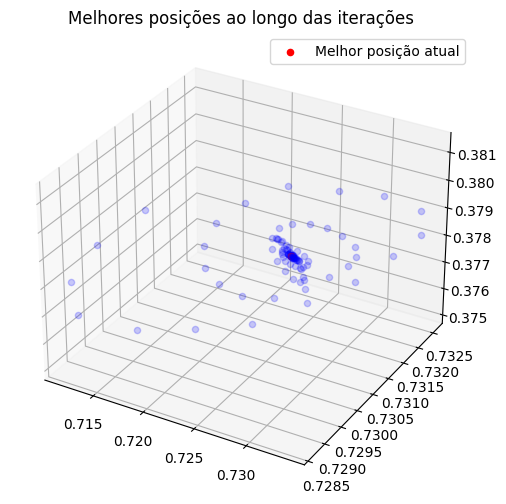

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
                              
Melhor custo: 7852049928000001.0


In [36]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("                              ")
print("Melhor custo:", pbest_cost[0])